In [ ]:
#!nvidia-smi

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas
!pip install pytorch_forecasting
!pip install yfinance
!pip install fix_yahoo_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 17.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 25.3 MB/s 
     |████████████████████████████████| 707 kB 46.8 MB/s 
     |████████████████████████████████| 308 kB 52.9 MB/s 
     |████████████████████████████████| 209 kB 54.9 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 5.9 MB 57.8 MB/s 
     |████████████████████████████████| 419 kB 42.1 MB/s 
     |████████████████████████████████| 78 kB 4.8 MB/s 
     |████████████████████████████████| 147 kB 71.0 MB/s 
     |████████████████████████████████| 112 kB 51.9 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=31afa7500d8811ada11e5ed34232d447e999149a97699418ef87a2b3c1fbcf90
  Stored in di

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import nltk
import copy
import statistics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
from torch.nn import RNNCellBase
from torch.nn import LSTMCell
import torch._VF
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime
import time
import math
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pytorch_forecasting.metrics as mt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from scipy import stats
# To print out all the elements belonging a tensor
import sys
import numpy
from numpy import save
numpy.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=20)
torch.set_printoptions(precision = 20)

device:  cpu


ModuleNotFoundError: ignored

In [ ]:
a = torch.tensor([[[1,2,3],[1,2,3],[2,3,4]],[[2,3,4],[2,1,3],[2,2,1]]])
print(a)
print(a.shape)
b = torch.transpose(a, 0,1)
print(b)

tensor([[[1, 2, 3],
         [1, 2, 3],
         [2, 3, 4]],

        [[2, 3, 4],
         [2, 1, 3],
         [2, 2, 1]]])
torch.Size([2, 3, 3])
tensor([[[1, 2, 3],
         [2, 3, 4]],

        [[1, 2, 3],
         [2, 1, 3]],

        [[2, 3, 4],
         [2, 2, 1]]])


In [ ]:
# Create a function to get train, validation and test set
def split_dataset(dataset, groundtruth, percent):
  '''
    Input:
    dataset: is a Dataframe in pandas  where each column is a feature
    groundtruth: is also a Dataframe with one column
    percent: a list of 3 elements, comprises the percentage of train, validation and test sets

    Purpose:
    This function is used to divide dataset into train, validation and test sets

    Output:
    train, validation, test set
  '''

  length = len(dataset)
  train_length = round(length*percent[0])
  train_set = dataset[:train_length]
  train_label = groundtruth[:train_length]
  valid_length = round(length*percent[1])
  if (percent[1] != 0): # validation is used
    valid_set = dataset[train_length: train_length+valid_length]
    valid_label = groundtruth[train_length: train_length + valid_length]
  test_set = dataset[train_length + valid_length:]
  test_label = groundtruth[train_length+ valid_length: ]
  if percent[1] != 0:
    return (train_set, valid_set, test_set),(train_label, valid_label, test_label)
  else:
    return (train_set, test_set),(train_label, test_label)


In [ ]:
# Create a dataset for LSTM model, includes return and realized volatility time series
def create_dataset(series_1,  series_2, names):
  '''
  Input:
    series_1: return time series
    series_2: volatility time series

  Output:
    A dataframe of 2 those time series

    This is used to create a dataset of 2 features: returns and realized volatilities
  '''
  data = pd.DataFrame(np.array([series_1, series_2]).T, columns = names)
  return data


In [ ]:
def batch_data(train, label, batch_size):
  '''
    Input:
      train: train dataframe
      label: label dataframe
      batch_size
    Output:
      Batch data

    Notes:
      + For each datapoint in train set, the corresponding label is the next realized volatility in label set
      + Thus, we cannot use the last datapoint of train set because there is no label for that point
  '''
  train_data = train#.values
  label_data = label#.values
  length = len(train)
  batched_data = [] # create a list to store batched data
  batched_label =[] # create a list to store bacthed label
  for datapoint in range((length-1)//batch_size): # because the last datapoint in train set does not have label
    batched_data.append(train_data[datapoint*batch_size: (datapoint+1)*batch_size])
    batched_label.append(label_data[datapoint*batch_size+1: (datapoint+1)*batch_size+1])
  if((length-1)/batch_size - (length-1)//batch_size != 0):
    batched_data.append(train_data[(length-1)//batch_size * batch_size:-1]) #  Remove the last datapoint in train set
    batched_label.append(batched_label[(length-1)//batch_size * batch_size+1:]) # Remove the first datapoint in the last batch of label set

  return batched_data, batched_label

In [ ]:
def devide_step(data, step_interval):
  '''
    Output: data that is grouped into steps. These steps are overlapped

    This function is used to remake a dataset that each element has a certain number of consecutive steps
  '''
  data_size = len(data)
  return [data[i:i+step_interval].values.tolist() for i in range(data_size - step_interval +1 )]

In [ ]:
# Building Metrics class
class _Loss(nn.Module):
    def __init__(self, size_average=None, reduce=None, reduction = 'mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class MAPELoss(_Loss):
  __constants__ = ['reduction']
  def __init__(self, size_average=None, reduce=None, reduction= "mean"):
    super(MAPELoss, self).__init__(size_average, reduce, reduction)

  def forward(self, forecast, groundtruth):
        return np.average(np.abs((groundtruth-forecast)/groundtruth)).detach()

In [ ]:
def train_iteration(model,optimizer,loss,batch_size,train_set,train_label,step):
  #print('step: ', step)
  batch = train_set[step*batch_size:(step+1)*batch_size] # Take one batch of data
  batch = torch.tensor(batch)
  reshaped_batch = torch.transpose(batch, 0,1)
  #print('batch data size: ', torch.tensor(reshaped_batch).shape)
  #groundtruth = torch.cuda.FloatTensor(train_label[step*batch_size:(step+1)*batch_size])
  groundtruth = torch.FloatTensor(train_label[step*batch_size:(step+1)*batch_size])
  # original shape of groundtruth (batch size, features) -> reshape (features, batch size)
  groundtruth = torch.transpose(groundtruth, 0,1)
  #print('groundtruth size: ',groundtruth.shape)
  optimizer.zero_grad()# At each epoch, gradient is set to zero again to avoid from accumulating
  pred = model(reshaped_batch).to(device) # Put inputs into the model
  """if(step == 1):
    print('pred: ', torch.reshape(pred, (-1,)))
    print('ground: ', groundtruth)"""
  #print('groundtruth: ', torch.reshape(groundtruth, (-1,)))
  #print('size of pred: ', torch.tensor(pred).shape)
  # add sqrt to use RMSE
  #loss = loss(torch.reshape(pred, (-1,)), torch.reshape(groundtruth, (-1,))) # Flatten all the matrices
  loss = loss(torch.unsqueeze(torch.reshape(pred, (-1,)),-1),torch.unsqueeze(torch.reshape(groundtruth, (-1,)),-1))
  #print('loss: ', loss)
  #print('before loss backward')
  loss.backward() # derivative - but it does not work now !!!!
  #print('loss backward')
  optimizer.step() # update training parameters

  return loss

In [ ]:
def test_step(model, data, loss, label_test):
  pred_test,_ = model(data)#.to(device)
  #print('pred_test: ', pred_test)
  #label_test = torch.gpu.FloatTensor(label_test)
  #label_test = torch.tensor(label_test, device = "cuda")
  label_test = torch.FloatTensor(label_test)
  label_test = torch.transpose(label_test, 0,1)
  #error = loss(torch.reshape(pred_test,(-1,)),torch.reshape(label_test,(-1,)))
  error = loss(torch.unsqueeze(torch.reshape(pred_test, (-1,)),-1), torch.unsqueeze(torch.reshape(label_test, (-1,)),-1))

  reshape_pred_test = torch.squeeze(pred_test, -1)
  result_reversed = []
  for step in range(len(pred_test)):
    step_repeated = reshape_pred_test[step].repeat((11,1)).T
    reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
    result_reversed.append(reversed_pred)

  gt = torch.tensor(label_test)
  gt_reversed = []
  for step in range(len(gt)):
    step_repeated = gt[step].repeat((11,1)).T
    reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
    gt_reversed.append(reversed_gt)

  flattened_pred = torch.tensor(result_reversed).flatten()
  flattened_gt = torch.tensor(gt_reversed).flatten()
  distance_real = loss(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))

  return error, distance_real

In [ ]:
def test_step_cnn(model, data, loss, label_test):
  pred_test = model(data)#.to(device)
  #print('pred_test: ', pred_test)
  #label_test = torch.gpu.FloatTensor(label_test)
  #label_test = torch.tensor(label_test, device = "cuda")
  label_test = torch.FloatTensor(label_test)
  #label_test = torch.transpose(label_test, 0,1)
  #error = loss(torch.reshape(pred_test,(-1,)),torch.reshape(label_test,(-1,)))
  error = loss(torch.unsqueeze(torch.reshape(pred_test, (-1,)),-1), torch.unsqueeze(torch.reshape(label_test, (-1,)),-1))

  reshape_pred_test = torch.squeeze(pred_test, -1)
  result_reversed = []
  for step in range(len(pred_test)):
    step_repeated = reshape_pred_test[step].repeat((11,1)).T
    reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
    result_reversed.append(reversed_pred)

  gt = torch.tensor(label_test)
  gt_reversed = []
  for step in range(len(gt)):
    step_repeated = gt[step].repeat((11,1)).T
    reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
    gt_reversed.append(reversed_gt)

  flattened_pred = torch.tensor(result_reversed).flatten()
  flattened_gt = torch.tensor(gt_reversed).flatten()
  distance_real = loss(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))

  return error, distance_real

In [ ]:
def train_model(model, optimizer, loss, batch_size, train_set,
          y_train, valid_set, y_valid, num_epoches, step_valid):
  # Reshape dimensions of validation set, original shape (num_vaid, 2, 2)
  valid_set = torch.tensor(valid_set)
  reshaped_valid = torch.transpose(valid_set, 0,1)
  valid_results = []
  loss_batch = []
  min_error = 9999999999.0
  best_model = copy.deepcopy(model)
  num_steps = len(train_set)//batch_size
  #print('num steps: ', num_steps)
  loss_epoches = []
  for e_i in range(num_epoches):
    loss_ei = 0.0
    print('epoches: ', e_i)
    for i in range(num_steps):
      step = i
      cost = train_iteration(model, optimizer, loss, batch_size,train_set,y_train, step)
      # train_results.append(cost)
      loss_ei += cost
      #print('step: ', iter_index, 'loss_per_batch: ', cost)

    if((e_i)%step_valid==0):
      error = test_step(model,reshaped_valid, loss, y_valid)
      print('epoch: ', e_i,  'loss_valid: ', error)
      valid_results.append(error)
      '''if(min_error > error):
        best_model = copy.deepcopy(model)
        min_error = error'''
    loss_epoches.append(loss_ei/num_steps)
    '''if(min_error > loss_epoches[-1]):
        best_model = copy.deepcopy(model)
        min_error = loss_epoches[-1]'''
    if(min_error > loss_epoches[-1]):
        best_model = copy.deepcopy(model)
        min_error = loss_epoches[-1]
    print('------------------epoch: ', e_i, 'loss per epoch: ', loss_epoches[-1],'------------------')
  return best_model, loss_epoches, valid_results


In [ ]:
# De-normalise data using MinMaxScaler
def reversed_data(data, scaler):
  return scaler.inverse_transform(data)

In [ ]:
# New Version
"""class attention(nn.Module):
  def __init__(self,input_shape, **kwargs):
    super(attention,self).__init__(**kwargs)
    weight_2 = torch.randn(input_shape[-1], 1)#.cuda() # return a tensor following Gaussian distribution
    weight_1 = torch.randn(input_shape[-1], input_shape[-1])
    bias = torch.randn(input_shape[1], 1)#.cuda()
    self.W1 = nn.Parameter(weight_1)
    self.W2 = nn.Parameter(weight_2)
    self.b = nn.Parameter(bias)
    self.tanh = nn.Tanh()
    # create one more 2-D weight

  def forward(self, x):
    m1 = x@self.W1 # batch_size, num_step, W1.shape[0] = input_shape[-1]
    m1 = self.tanh(m1)
    et = torch.squeeze(m1@self.W2) # batch_size, num_step, 1
    # cange multiplcation operation to Matrix times x
    # put Tanh on et
    # multiply et with weight
    at = nn.Softmax()(et)
    #print('softmax: ', at)
    at = torch.unsqueeze(at,-1)
    #print('unsqueeze: ', at)
    output = x*at
    #print('output: ', output)
    return torch.sum(output,1)"""

"class attention(nn.Module):\n  def __init__(self,input_shape, **kwargs):\n    super(attention,self).__init__(**kwargs)\n    weight_2 = torch.randn(input_shape[-1], 1)#.cuda() # return a tensor following Gaussian distribution\n    weight_1 = torch.randn(input_shape[-1], input_shape[-1])\n    bias = torch.randn(input_shape[1], 1)#.cuda()\n    self.W1 = nn.Parameter(weight_1)\n    self.W2 = nn.Parameter(weight_2)\n    self.b = nn.Parameter(bias)\n    self.tanh = nn.Tanh()\n    # create one more 2-D weight\n\n  def forward(self, x):\n    m1 = x@self.W1 # batch_size, num_step, W1.shape[0] = input_shape[-1]\n    m1 = self.tanh(m1)\n    et = torch.squeeze(m1@self.W2) # batch_size, num_step, 1 \n    # cange multiplcation operation to Matrix times x\n    # put Tanh on et\n    # multiply et with weight\n    at = nn.Softmax()(et)\n    #print('softmax: ', at)\n    at = torch.unsqueeze(at,-1)\n    #print('unsqueeze: ', at)\n    output = x*at\n    #print('output: ', output)\n    return torch.sum(ou

In [ ]:
# Retrun attention weights
class attention(nn.Module):
  def __init__(self,input_shape, **kwargs):
    super(attention,self).__init__(**kwargs)
    weight_2 = torch.randn(input_shape[-1], 1)#.cuda() # return a tensor following Gaussian distribution
    weight_1 = torch.randn(input_shape[-1], input_shape[-1])
    bias = torch.randn(input_shape[1], 1)#.cuda()
    self.W1 = nn.Parameter(weight_1)
    self.W2 = nn.Parameter(weight_2)
    self.b = nn.Parameter(bias)
    self.tanh = nn.Tanh()
    # create one more 2-D weight

  def forward(self, x):
    m1 = x@self.W1 # batch_size, num_step, W1.shape[0] = input_shape[-1]
    m1 = self.tanh(m1)
    et = torch.squeeze(m1@self.W2) # batch_size, num_step, 1
    # cange multiplcation operation to Matrix times x
    # put Tanh on et
    # multiply et with weight
    at = nn.Softmax()(et)
    #print('softmax: ', at)
    at = torch.unsqueeze(at,-1)
    #print('unsqueeze: ', at)
    output = x*at
    #print('output: ', output)
    return torch.sum(output,1), at

In [ ]:
# OLD VERSION
"""class attention(nn.Module):
  def __init__(self,input_shape, **kwargs):
    super(attention,self).__init__(**kwargs)
    weight_1 = torch.randn(input_shape[-1], 1)#.cuda() # return a tensor following Gaussian distribution
    weight_2 = torch.randn(input_shape[-1], input_shape[-1])
    bias = torch.randn(input_shape[1], 1)#.cuda()
    self.W1 = nn.Parameter(weight_1)
    self.b = nn.Parameter(bias)
    # create one more 2-D weight

  def forward(self, x):
    et = torch.squeeze(torch.tanh(x@self.W + self.b))
    # cange multiplcation operation to Matrix times x
    # put Tanh on et
    # multiply et with weight
    at = nn.Softmax()(et)
    #print('softmax: ', at)
    at = torch.unsqueeze(at,-1)
    #print('unsqueeze: ', at)
    output = x*at
    #print('output: ', output)
    return torch.sum(output,1)"""

"class attention(nn.Module):\n  def __init__(self,input_shape, **kwargs):\n    super(attention,self).__init__(**kwargs)\n    weight_1 = torch.randn(input_shape[-1], 1)#.cuda() # return a tensor following Gaussian distribution\n    weight_2 = torch.randn(input_shape[-1], input_shape[-1])\n    bias = torch.randn(input_shape[1], 1)#.cuda()\n    self.W1 = nn.Parameter(weight_1)\n    self.b = nn.Parameter(bias)\n    # create one more 2-D weight\n\n  def forward(self, x):\n    et = torch.squeeze(torch.tanh(x@self.W + self.b))\n    # cange multiplcation operation to Matrix times x\n    # put Tanh on et\n    # multiply et with weight\n    at = nn.Softmax()(et)\n    #print('softmax: ', at)\n    at = torch.unsqueeze(at,-1)\n    #print('unsqueeze: ', at)\n    output = x*at\n    #print('output: ', output)\n    return torch.sum(output,1)"

In [ ]:
# Using LSTM from the Torch library

class LSTM_sequence_multiple2one(nn.Module):
  '''
    This is a LSTM layer, the number of cells depends on users
    At every cell, the input is from one time step ( data point ) of data ( one data point might include more than
    one feature)
    The first LSTM cell does not have hidden state and cell state in advance. Thus, they are set to zeros
    For each cell, the output (which is hidden state) is also the predicted volatility for the next step
    In summary, the output of this function is a list of consecutive predicted volatilities

    Args:
      + hidden_size: The size of hidden state
      + input_size: The number of features at one time step
      + num_cell: the number of LSTM blocks

    Inputs:
      + A list of data with size of ( num_step, batch_size, input_size )

    Outputs:
      + A list of hidden states at all time steps considered ( these are also predicted volatilities )
  '''
  def __init__(self, hidden_size, input_size, num_cell, dense_1):
    super(LSTM_sequence_multiple2one, self).__init__()
    constant = torch.abs(torch.empty(1).normal_(mean=0.0,std=0.01))#.cuda()
    self.constant = nn.Parameter(constant)
    self.hidden_size = hidden_size
    self.num_cell = num_cell
    self.input_size = input_size
    self.dense = nn.Linear(hidden_size ,dense_1)#.cuda()
    self.dense_2 = nn.Linear(32,1)#.cuda()
    self.dense_3 = nn.Linear(dense_1,32)
    self.relu = nn.ReLU()
    self.lstm = nn.LSTM(input_size, hidden_size)#.cuda()
    self.attn = attention((-1,num_cell, hidden_size))
    self.drop = nn.Dropout(p = 0.1)
    self.tanh = nn.Tanh()
  def forward(self, input): # (num_sep, batch_size, input_size)
    """hidden_store = [] # declare a list to store hidden state results
    hx, cx = self.sequence_lstm[0](input[0])
    #print('input 0: ', input[0])
    #hx, cx = hx.detach(), cx.detach() # add
    # remove detach()
    hidden_store.append(hx.detach().cpu().numpy()) # add the first hidden state output and transform from a Tensor to Numpy array
    if(self.num_cell > 1):
      for cell in range(self.num_cell -1):
        #print('input 1:', input[cell+1])
        hx,cx = self.sequence_lstm[cell+1](input[cell+1],(hx,cx))
        #hx, cx = hx.detach(), cx.detach() # add
        hidden_store.append(hx.detach().cpu().numpy())
        #print(' hidden state final: ', torch.tensor(hx).device)
        #print(' cell state final: ', torch.tensor(cx).device)
    #print('hidden_states:', hidden_store)
    # hidden state is different from each other
    x = torch.tensor(hidden_store, requires_grad= True) # Convert from numpy array ( stored in a list ) to a Tensor"""
    #x = torch.tensor(input, requires_grad = True)
    x,(h,c) = self.lstm(input)
    x = torch.tensor(x)
    x = torch.transpose(x,0,1)
    # attn
    x,w = self.attn(x) # (batch_size, hidden_size)
    # concat previous output (batch_size, 1) to the context vector
    #x = torch.concat([x,self.previous_output], axis = 1)
    #print('attention: ', x)
    #x = self.tanh(x)
    x = self.dense(x)# something is wrong here
    #x = self.drop(x)

    x = self.dense_3(x)# something is wrong here
    # put Tanh on x
    #print('dense: ', x)
    #x = self.drop(x)
    x = self.dense_2(x)
    #x = self.relu(x)#+self.constant
    #x = torch.abs(x) # If use Normal Normalization, remove this line
    #print('relu: ', x)
    x = torch.transpose(x,0,1)
    x = torch.unsqueeze(x, -1)
    return x,w

change the size of 1st FC to hidden state size
put input in lstm straight forward, remove x = torch.tensor(input, require_grads = True )

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/harshalchaudhari35/cross-correlation-cc/main/data/consolidated_coin_data.csv")

In [ ]:
print((data))

      Currency          Date      Open      High       Low     Close  \
0           0x  Feb 11, 2018      1.09      1.09  0.934155  0.979054   
1           0x  Feb 10, 2018      1.14       1.2  0.985705       1.1   
2           0x  Feb 09, 2018      1.08      1.15      1.01      1.14   
3           0x  Feb 08, 2018  0.988963      1.13  0.988963      1.07   
4           0x  Feb 07, 2018      1.01      1.16  0.902145  0.993355   
...        ...           ...       ...       ...       ...       ...   
83151  zilliqa  Jan 29, 2018  0.097167  0.099824  0.077958  0.089273   
83152  zilliqa  Jan 28, 2018  0.101224  0.112499  0.095968  0.097296   
83153  zilliqa  Jan 27, 2018  0.118157  0.120932  0.091614  0.100976   
83154  zilliqa  Jan 26, 2018  0.135555  0.159557  0.091337  0.119375   
83155  zilliqa  Jan 25, 2018  0.136822  0.136822  0.135573  0.136039   

         Volume Market Cap  
0       4888770  555363000  
1      10828700  576535000  
2       5979420  545842000  
3      12992800  50

In [ ]:
data_count = data['Currency'].value_counts()
for i in data_count.index:
  if data_count[i] < 1500:
    data = data[data['Currency'] != i]

In [ ]:
print(data['Currency'].value_counts().index)

Index(['bitcoin', 'litecoin', 'peercoin', 'ripple', 'nxt', 'dogecoin'], dtype='object')


In [ ]:
CCs_list = ['BTC-USD', 'ETH-USD','BNB-USD','USDT-USD','ADA-USD', 'SOL1-USD','XRP-USD', 'DOT1-USD', 'SHIB-USD', 'DOGE-USD', 'USDC-USD','LUNA1-USD', 'UNI3-USD', 'LINK-USD', 'LTC-USD','BCH-USD',
'XLM-USD', 'THETA-USD', 'ETC-USD','AVAX-USD', 'MATIC-USD', 'ALGO-USD', 'VET-USD','PPC-USD']
start_btc = datetime(2014,9,17)
start_eth = datetime(2015,8,7)
start_bnb = datetime(2017,7,25)
start_tet = datetime(2015,2,25)
start_ada = datetime(2017,10,1)
start_sol = datetime(2020,4,10)
start_xrp = datetime(2014,9,17)
start_pol = datetime(2020,8,20)
start_shi = datetime(2020,8,1)
start_dog = datetime(2014,9,17)
start_usd = datetime(2018,10,8)
start_ter = datetime(2019,9,18)
start_uni = datetime(2020,9,22)
start_cha = datetime(2017,9,20)
start_lit = datetime(2014,9,17)
start_bch = datetime(2017,7,23)
start_ste = datetime(2014,9,17)
start_the = datetime(2018,1,17)
start_etc = datetime(2016,7,24)
start_ava = datetime(2020,7,13)
start_mat = datetime(2019,4,28)
start_algo = datetime(2019,9,18)
start_vet = datetime(2018,8,3)
start_ppc = datetime(2014,9,17)
datetime_list = [start_btc, start_eth, start_bnb, start_tet, start_ada, start_sol, start_xrp, start_pol, start_shi,start_dog, start_usd, start_ter, start_uni, start_cha, start_lit, start_bch, start_ste, start_the, start_etc, start_ava, start_mat, start_algo, start_vet, start_ppc]

In [ ]:
print(len(CCs_list))
print(len(datetime_list))

24
24


In [ ]:
end = datetime.now()
close_list = []
for index in range(len(CCs_list)):
  close = DataReader([CCs_list[index]], 'yahoo', datetime_list[index], end)['Close']
  close['Index'] = close.index
  close.drop_duplicates(subset ="Index", keep = False, inplace = True)
  del close['Index']
  close_list.append(close)



In [ ]:
sorted_length = []
for crypto in close_list:
  sorted_length.append(len(crypto))

sorted_length.sort()
sorted_length = sorted_length[::-1]
boundary = sorted_length[9]

In [ ]:
for crypto in close_list:
  if len(crypto) >= boundary:
    print(crypto)

Symbols          BTC-USD
Date                    
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
...                  ...
2022-04-13  41166.730469
2022-04-14  39935.515625
2022-04-15  40553.464844
2022-04-16  40424.484375
2022-04-17  40048.632812

[2770 rows x 1 columns]
Symbols         ETH-USD
Date                   
2017-11-09   320.884003
2017-11-10   299.252991
2017-11-11   314.681000
2017-11-12   307.907990
2017-11-13   316.716003
...                 ...
2022-04-13  3118.344238
2022-04-14  3019.909424
2022-04-15  3040.916504
2022-04-16  3062.310303
2022-04-17  3050.482666

[1621 rows x 1 columns]
Symbols        BNB-USD
Date                  
2017-11-09    1.990770
2017-11-10    1.796840
2017-11-11    1.670470
2017-11-12    1.519690
2017-11-13    1.686620
...                ...
2022-04-13  423.130157
2022-04-14  414.663727
2022-04-15  417.293732
2022-04-16  417.478455
2022-04-17  414.449524

[1621 rows x 

In [ ]:
# Sort the order of cryptocurrencies regarding the length
sorted_length = []
for crypto in close_list:
  sorted_length.append(len(crypto))

sorted_length.sort()
sorted_length = sorted_length[::-1]

# Take the top 10 longest CCs
boundary = sorted_length[9]
print(boundary)
top_10 =[]
for crypto in close_list:
  if len(crypto) >= boundary and len(top_10) < 10:
    top_10.append(crypto)


1621


In [ ]:
data_abc = pd.concat(close_list, axis = 1)

In [ ]:
# Add CVI index ( 30 days implied CCs volatility)
cvi = pd.read_csv('cvi_2.csv')
date_index = pd.DatetimeIndex(np.array(cvi['Date'].values))
cvi.index = date_index
cvi_close = cvi['Price']

In [ ]:
data = pd.concat(top_10, axis = 1).dropna()
data

Symbols,BTC-USD,ETH-USD,BNB-USD,USDT-USD,ADA-USD,XRP-USD,DOGE-USD,LINK-USD,LTC-USD,BCH-USD
Date,,,,,,,,,,
2017-11-09,7143.580078,320.884003,1.990770,1.008180,0.032053,0.217488,0.001415,0.223969,64.269699,654.302979
2017-11-10,6618.140137,299.252991,1.796840,1.006010,0.027119,0.206483,0.001163,0.187602,59.260101,1007.419983
2017-11-11,6357.600098,314.681000,1.670470,1.008990,0.027437,0.210430,0.001201,0.179770,62.303299,1340.449951
2017-11-12,5950.069824,307.907990,1.519690,1.012470,0.023977,0.197339,0.001038,0.170898,59.005402,1388.859985
2017-11-13,6559.490234,316.716003,1.686620,1.009350,0.025808,0.203442,0.001211,0.183071,61.396500,1353.989990
...,...,...,...,...,...,...,...,...,...,...
2022-04-13,41166.730469,3118.344238,423.130157,1.000275,0.974696,0.723850,0.140080,14.183898,110.482452,341.976013
2022-04-14,39935.515625,3019.909424,414.663727,1.000127,0.932412,0.726819,0.143920,13.646021,107.411041,337.560822
2022-04-15,40553.464844,3040.916504,417.293732,1.000239,0.954717,0.785675,0.146026,14.120528,111.109344,340.612915


In [ ]:
# Merge top 10 CCs
data = pd.concat(top_10, axis = 1).dropna()#[:-41] # -59 in the past
del data['BNB-USD']
data['BCH-USD']  = data_abc['XLM-USD']
data['USDT-USD']  = data_abc['BCH-USD']
data.rename(columns = {'BCH-USD': 'XLM-USD', 'USDT-USD': 'BCH-USD'}, inplace = True)
data['ETC-USD'] = data_abc['ETC-USD']
data['BCH-USD'] = data_abc['BCH-USD']
print(data)
data.describe()

Symbols          BTC-USD      ETH-USD      BCH-USD   ADA-USD   XRP-USD  \
Date                                                                     
2017-11-09   7143.580078   320.884003   654.302979  0.032053  0.217488   
2017-11-10   6618.140137   299.252991  1007.419983  0.027119  0.206483   
2017-11-11   6357.600098   314.681000  1340.449951  0.027437  0.210430   
2017-11-12   5950.069824   307.907990  1388.859985  0.023977  0.197339   
2017-11-13   6559.490234   316.716003  1353.989990  0.025808  0.203442   
...                  ...          ...          ...       ...       ...   
2022-04-13  41166.730469  3118.344238   341.976013  0.974696  0.723850   
2022-04-14  39935.515625  3019.909424   337.560822  0.932412  0.726819   
2022-04-15  40553.464844  3040.916504   340.612915  0.954717  0.785675   
2022-04-16  40424.484375  3062.310303   343.198151  0.952640  0.781841   
2022-04-17  40048.632812  3050.482666   334.238922  0.937525  0.768084   

Symbols     DOGE-USD   LINK-USD     L

Symbols,BTC-USD,ETH-USD,BCH-USD,ADA-USD,XRP-USD,DOGE-USD,LINK-USD,LTC-USD,XLM-USD,ETC-USD
count,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000
mean,19704.320628,1058.964611,532.474557,0.493504,0.542492,0.057749,9.256846,107.340887,0.202697,18.984776
std,17895.776617,1250.518465,457.887282,0.669718,0.387678,0.105183,11.119727,66.317456,0.142690,19.089856
min,3236.761719,84.308296,77.365776,0.023961,0.139635,0.001038,0.145255,23.464331,0.028182,3.472387
25%,7315.540039,197.224716,256.755402,0.054011,0.270088,0.002513,0.492214,54.267277,0.079730,5.782465
50%,9858.150391,391.024170,388.820007,0.118316,0.401533,0.003279,2.774105,85.075897,0.182546,9.519626
75%,35787.246094,1783.797974,615.312012,0.916782,0.750973,0.055980,16.123285,148.488007,0.287963,28.652197
max,67566.828125,4812.087402,3923.070068,2.968239,3.377810,0.684777,52.198696,386.450775,0.896227,134.101791


In [ ]:
print(data.columns)

Index(['BTC-USD', 'ETH-USD', 'BCH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD',
       'LINK-USD', 'LTC-USD', 'XLM-USD', 'ETC-USD'],
      dtype='object', name='Symbols')


In [ ]:
# returns
returns = data.pct_change().dropna()
print(returns)

Symbols      BTC-USD   ETH-USD   BCH-USD   ADA-USD   XRP-USD  DOGE-USD  \
Date                                                                     
2017-11-10 -0.073554 -0.067411  0.539684 -0.153933 -0.050600 -0.178092   
2017-11-11 -0.039368  0.051555  0.330577  0.011726  0.019115  0.032674   
2017-11-12 -0.064101 -0.021523  0.036115 -0.126107 -0.062211 -0.135720   
2017-11-13  0.102422  0.028606 -0.025107  0.076365  0.030927  0.166667   
2017-11-14  0.011626  0.066037 -0.059424  0.016352  0.031375 -0.022296   
...              ...       ...       ...       ...       ...       ...   
2022-04-13  0.025906  0.029029  0.122756  0.020469  0.010097  0.014514   
2022-04-14 -0.029908 -0.031566 -0.012911 -0.043382  0.004102  0.027413   
2022-04-15  0.015474  0.006956  0.009042  0.023922  0.080978  0.014633   
2022-04-16 -0.003181  0.007035  0.007590 -0.002175 -0.004880 -0.015847   
2022-04-17 -0.009298 -0.003862 -0.026105 -0.015867 -0.017596 -0.010629   

Symbols     LINK-USD   LTC-USD   XLM-

In [ ]:
# Calcualte the realized variances ( percent in unit )
rv = (returns**2).rolling(5).mean().dropna()

In [ ]:
# add CVI to rv
rv['CVI'] = cvi_close
rv = rv.dropna()
vol = rv**(1/2)*100
vol['CVI'] = cvi_close
vol = vol[:-6]
print(vol)

Symbols      BTC-USD   ETH-USD    BCH-USD   ADA-USD   XRP-USD   DOGE-USD  \
Date                                                                       
2019-03-31  1.208438  2.145941   3.438561  5.548918  1.273534   0.782506   
2019-04-01  0.693537  1.133377   1.167353  4.415818  0.838033   8.201313   
2019-04-02  7.790290  7.052229  18.288613  9.171081  5.585395  10.200204   
2019-04-03  7.830313  7.015931  21.754639  8.826569  5.705253  11.782399   
2019-04-04  7.842807  7.077944  21.820774  8.975551  5.831761  13.984218   
...              ...       ...        ...       ...       ...        ...   
2022-01-08  2.899870  4.674845   3.532712  3.968607  3.115944   3.037397   
2022-01-09  2.855580  4.754830   3.466067  3.987500  3.111420   3.029865   
2022-01-10  1.736588  3.934054   2.652011  3.505981  1.744843   2.864412   
2022-01-11  1.948539  4.215326   2.742854  3.859989  2.539220   4.238500   
2022-01-12  1.627838  3.538591   2.788232  5.433569  2.861037   4.653509   

Symbols    

In [ ]:
#@title Default title text { form-width: "10px" }
vol.describe()

Symbols,BTC-USD,ETH-USD,BCH-USD,ADA-USD,XRP-USD,DOGE-USD,LINK-USD,LTC-USD,XLM-USD,ETC-USD,CVI
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,3.397548,4.305781,4.829616,5.083482,4.751734,5.830880,5.982234,4.586766,4.856168,4.875433,87.263217
std,2.037857,2.521460,3.662238,3.033115,4.227940,12.483160,3.686251,2.778046,3.881532,3.971182,20.442534
min,0.300223,0.717276,0.651198,0.861721,0.407212,0.401373,0.763564,0.434787,0.608442,0.431091,50.324800
25%,2.066509,2.731600,2.589148,2.966539,2.176969,1.937595,3.608892,2.582667,2.664732,2.422156,70.388650
50%,2.988295,3.762151,3.825878,4.268732,3.557140,3.243344,5.152295,3.958589,3.910074,3.811134,87.260900
75%,4.264362,5.248040,5.730906,6.351555,5.583777,5.731634,7.118904,5.909475,5.751627,5.807602,97.984100
max,18.051162,21.594270,24.177459,20.629837,28.104758,161.628465,29.072794,19.738620,35.997662,30.134724,170.550500


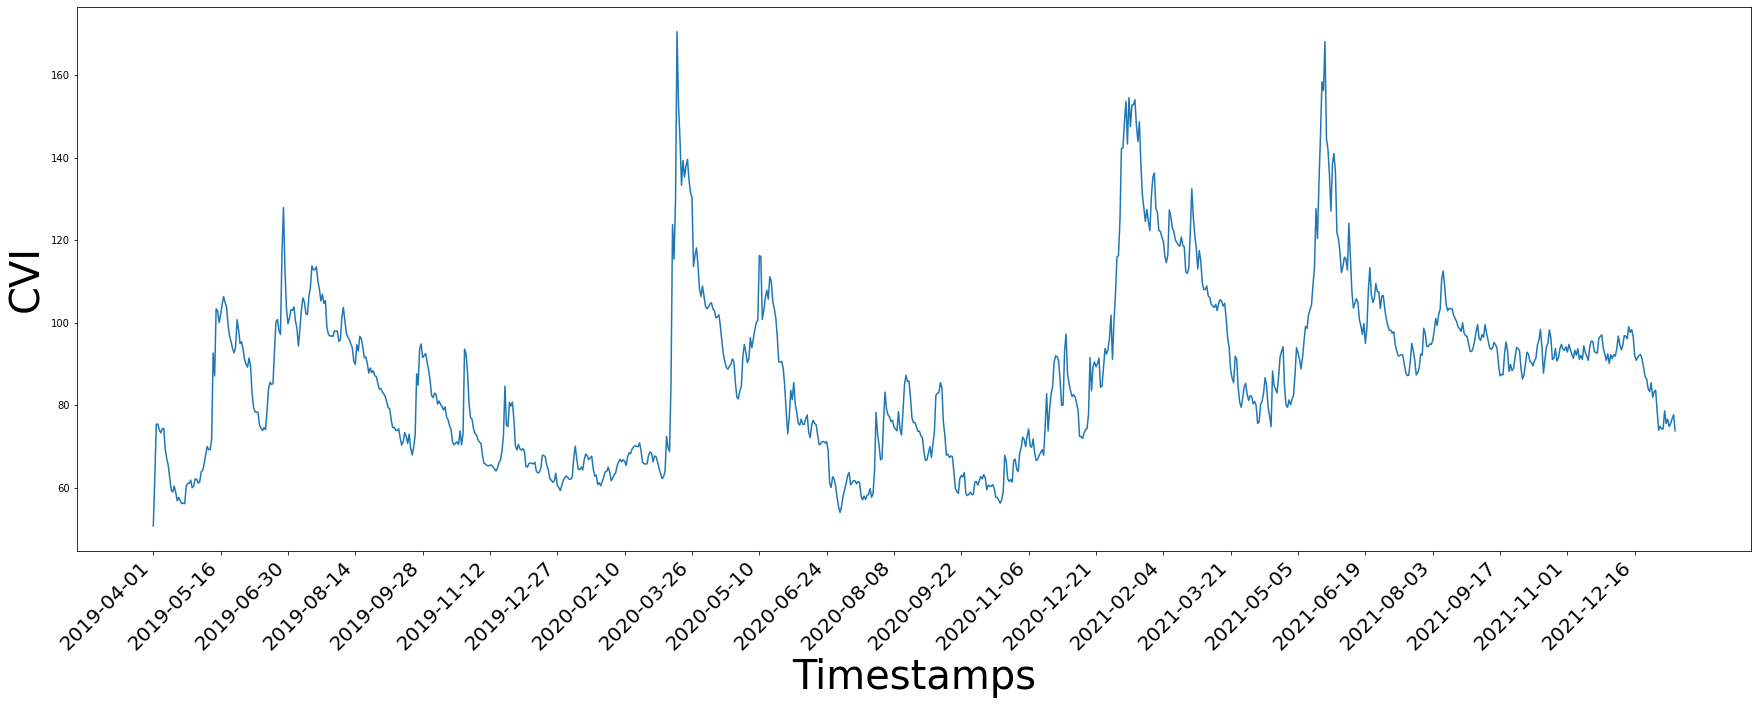

In [ ]:
plt.figure(figsize =(30,10))
plt.plot(vol[1:].index, vol['CVI'].values[1:])
plt.xlabel('Timestamps', fontsize = 40)
plt.ylabel('CVI', fontsize = 40)
plt.xticks(vol[1:].index[::45], rotation = 45, ha = "right", fontsize = 20)
plt.savefig('cvi_index.png', bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [ ]:
num_cells = 20

In [ ]:
# Normalization
"""scaler = preprocessing.MinMaxScaler(feature_range = (0,1))# because volatilities after normalising are still so small, using this range might be better
data_normalised = scaler.fit_transform(rv)
data_frame_normalised = pd.DataFrame(data = np.array(data_normalised))
data_frame_normalised.columns = rv.columns"""

scaler = preprocessing.StandardScaler() # because volatilities after normalising are still so small, using this range might be better
data_normalised = scaler.fit_transform(vol)
data_frame_normalised = pd.DataFrame(data = np.array(data_normalised))
data_frame_normalised.columns = vol.columns
# Cut timepoints after 2/11/2021 ( used as another period of time)
time_frame_2 = data_frame_normalised[-204-num_cells+1:] # Add num_step because we
#data_frame_normalised = data_frame_normalised[:-205]

label = data_frame_normalised['CVI']
#data = data_frame_normalised[:-1]
# remove the first row because the value of VCI is zero
data = data_frame_normalised[1:]
del data['CVI']
#label = label[1:]
label = label[1:]
(train,valid,test), (train_label, valid_label, test_label) = split_dataset(data, label, [0.7,0.15,0.15])

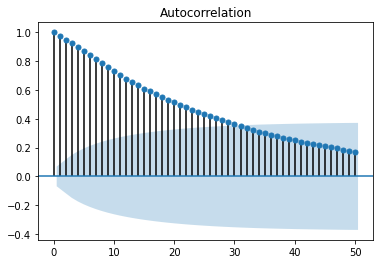

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(vol['CVI'][:-200]), lags = 50)
plt.savefig('autocorrelation.png',  bbox_inches='tight', pad_inches = 0.1)

In [ ]:
# Second version for dataset: we won't normalize the data as the original values are in [0,1] space already
"""data = vol[1:]
del data['CVI']
(train,valid,test), (train_label, valid_label, test_label) = split_dataset(data, label, [0.7,0.15,0.15])"""

"data = vol[1:]\ndel data['CVI'] \n(train,valid,test), (train_label, valid_label, test_label) = split_dataset(data, label, [0.7,0.15,0.15])"

In [ ]:
print(train)

Symbols   BTC-USD   ETH-USD   BCH-USD   ADA-USD   XRP-USD  DOGE-USD  LINK-USD  \
1       -1.327541 -1.258779 -1.000498 -0.220233 -0.926130  0.189984 -0.404479   
2        2.156628  1.089764  3.676879  1.348319  0.197276  0.350189 -0.261294   
3        2.176277  1.075361  4.623766  1.234680  0.225639  0.476998 -0.209484   
4        2.182411  1.099968  4.641834  1.283822  0.255575  0.653468 -0.129649   
5        2.215761  1.221382  4.647401  1.326731  0.540239  0.658258  0.033651   
..            ...       ...       ...       ...       ...       ...       ...   
709     -0.099523  0.278544 -0.685976 -0.333697 -0.409321  0.258061 -0.264486   
710     -0.037751  0.381143 -0.713783 -0.316200 -0.512420  0.267782 -0.140233   
711      0.107856 -0.139586 -0.712659 -0.394376 -0.489698  0.261059 -0.144689   
712     -0.210155 -0.225416 -0.780622  0.027704 -0.433303  0.257570 -0.016109   
713      0.374007  0.084216  0.047048  0.245550 -0.313477  0.061058 -0.571823   

Symbols   LTC-USD   XLM-USD

In [ ]:
print(train_label)

1     -1.786806
2     -1.219098
3     -0.581212
4     -0.576856
5     -0.647244
         ...   
709    0.822698
710    0.805128
711    0.841213
712    0.768035
713    0.857599
Name: CVI, Length: 713, dtype: float64


In [ ]:
data.columns[i]

IndexError: ignored

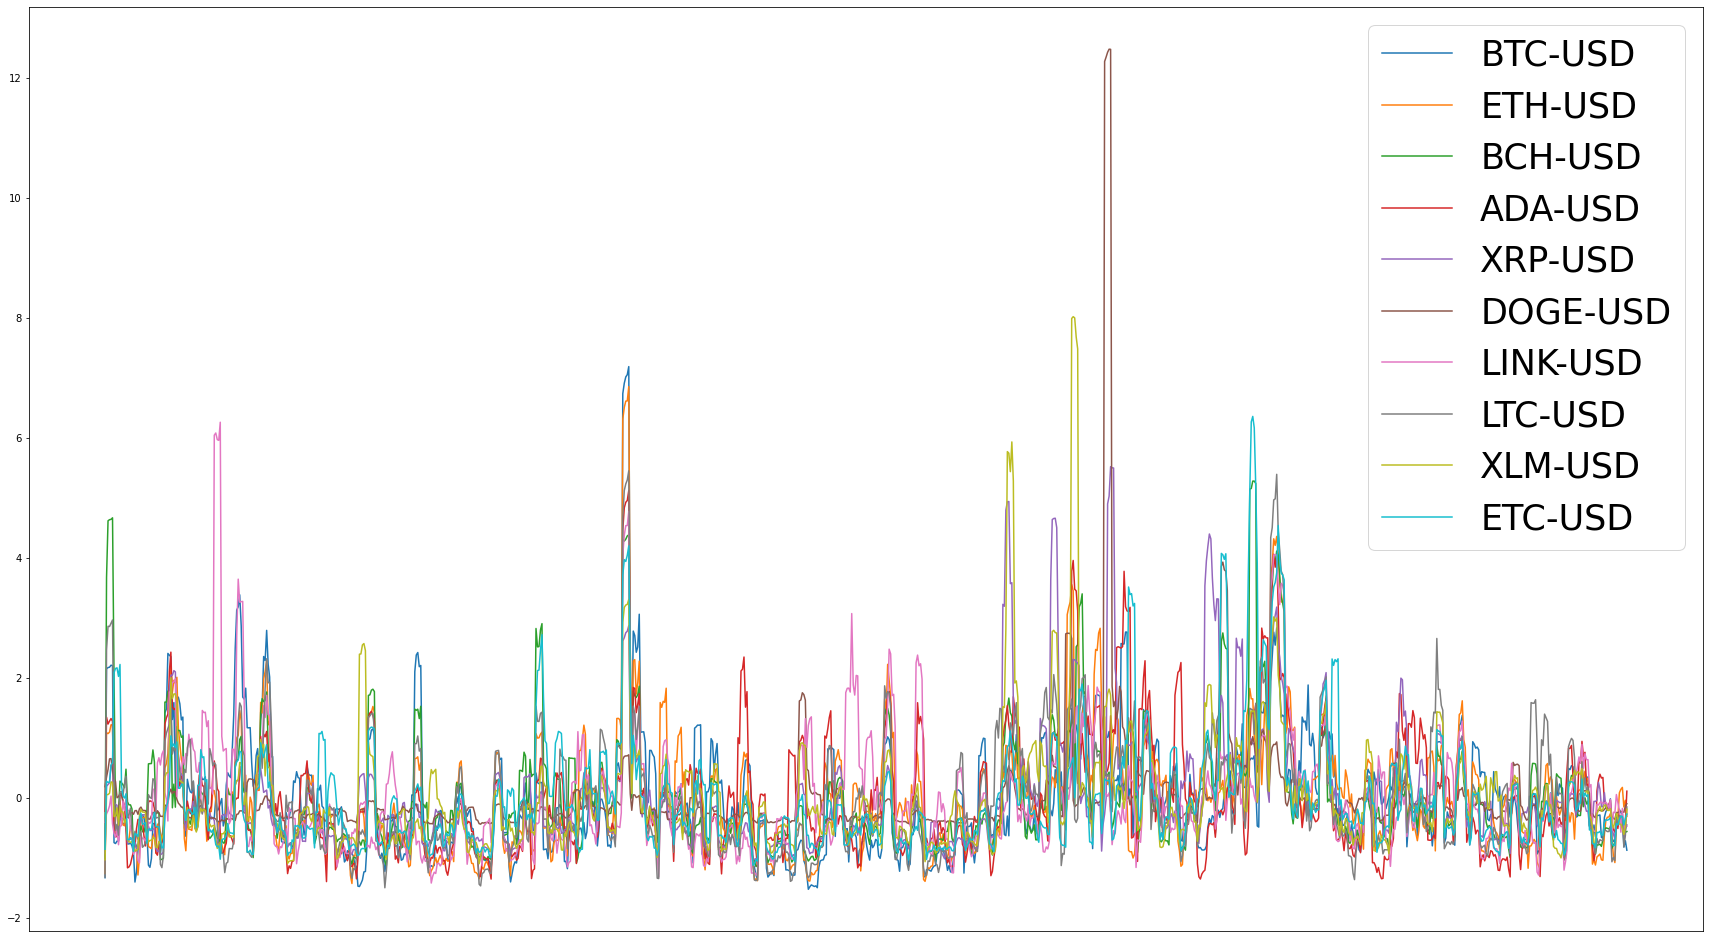

In [ ]:
# Plot time series
plt.figure(figsize= (30,17))
for i in range(len(data.columns)):
  plt.plot(vol[1:].index, data[data.columns[i]].values)
plt.legend((data.columns),  prop={'size': 35})
#plt.xlabel('Timestamps', fontsize = 35)
#plt.ylabel('Normalised Realized Volatility', fontsize = 35)
#plt.xticks(vol[1:].index[::15], ha = "right", rotation = 45, fontsize = 20)
plt.xticks([])

plt.savefig('series.png',  bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [ ]:
im = plt.imread('series.png')

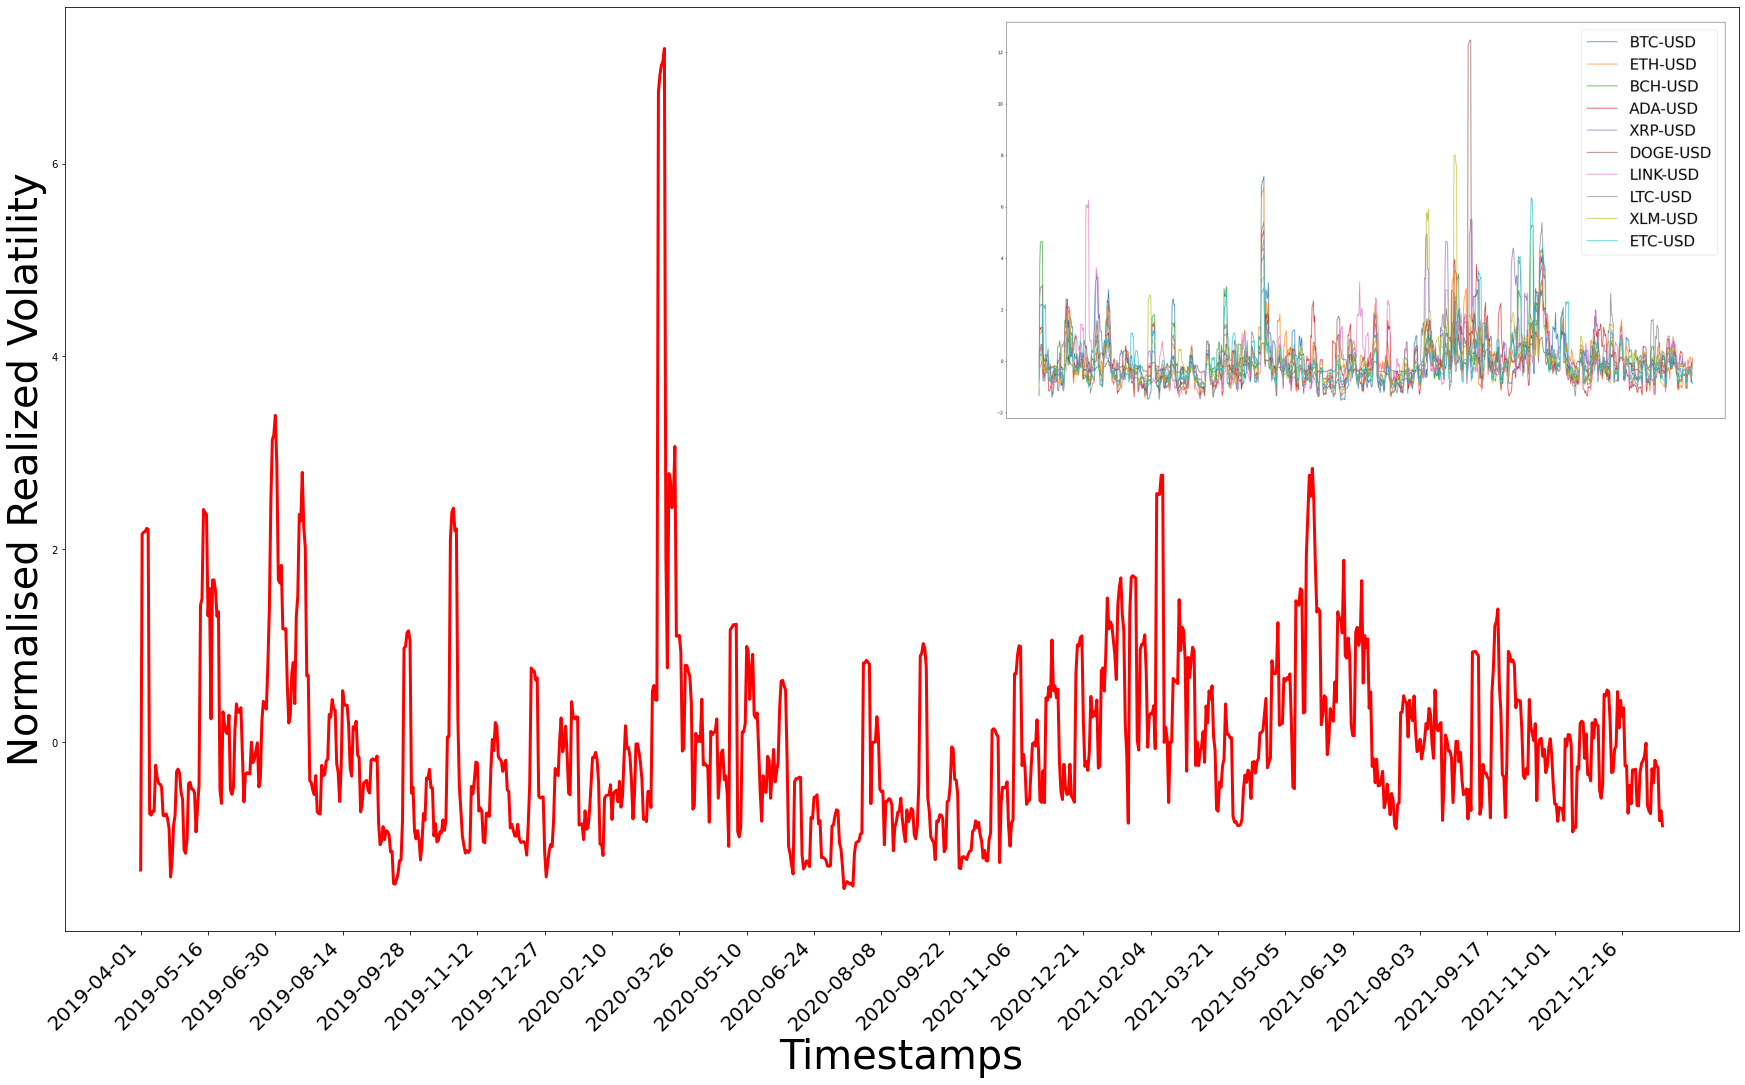

In [ ]:
# Plot the correlations
fig,ax = plt.subplots(figsize = (30,17))
ax.plot(range(len(vol[1:].index)), data['BTC-USD'].values, 'r', linewidth = 3)
#ax.plot([0,1,4,5,6,7,8,10,75,76], cor_pd_cvi_sm[0][['BTC-USD','ETH-USD','ADA-USD','XRP-USD', 'LTC-USD', 'BCH-USD', 'XLM-USD', 'ETC-USD', 'DOGE-USD' , 'LINK-USD']].values, '*g', markersize = 12)
ax.set_xticks(range(len(vol[1:].index))[::45])
ax.set_xticklabels(vol[1:].index.format()[::45])
plt.xlabel('Timestamps', fontsize = 40)
plt.ylabel('Normalised Realized Volatility', fontsize = 40)
plt.xticks(rotation = 45, ha = "right", fontsize = 20)
newax = fig.add_axes([0.54,0.54,0.37,0.33])
newax.imshow(im)
newax.axis('off')
plt.savefig('series.png',bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [ ]:
# Plot CVI time series
plt.figure(figsize= (30,17))
plt.plot(vol[1:].index, vol[1:]['CVI'].values)
plt.xlabel('Timestamps', fontsize = 35)
plt.ylabel('Normalised Realized Volatility', fontsize = 35)
plt.xticks(vol[1:].index[::15], ha = "right", rotation = 45, fontsize = 20)
plt.savefig('labels.png')
plt.show()

In [ ]:
fff

**Correlation of return time series**


**Pearson**

In [ ]:
returns.columns.values
cnames = np.array(['BTC', 'ETH', 'BCH', 'ADA', 'XRP', 'DOGE', 'LINK','LTC', 'XLM', 'ETC'])

In [ ]:
returns_squared = returns**2
print(returns_squared)
returns_numpy = np.array(data.values.T)
pearson = np.corrcoef(returns_numpy)
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(pearson, cmap = 'YlGnBu', xticklabels= cnames, yticklabels= cnames, annot = True, ax = ax)
plt.savefig('corr.png', bbox_inches='tight',pad_inches = 0.1)

In [ ]:
print(returns_numpy.shape)

**Spearman**

In [ ]:
data_numpy = np.array(data.values)
spearman,_ = stats.spearmanr(data_numpy)
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(spearman, cmap = 'YlGnBu', xticklabels= cnames, yticklabels= cnames, annot = True, ax = ax)
plt.savefig('corr_spearman.png', bbox_inches='tight',pad_inches = 0.1)

In [ ]:
print(spearman.shape)

Bascially, the relationshp between the chosen CCs is not very high -> appropriate for the usage of prediction

In [ ]:
num_cells = 20
batch_size = 32 # 32 in the past
num_iters =  2500
step_valid = 10 # run on validation set every 10 steps
num_epoches = len(train)//batch_size

In [ ]:
model_multiple2one =   LSTM_sequence_multiple2one(100,10,num_cells,64)

Modify Hidden size

In [ ]:
# Declare omptimizer and Objective function
# alpha = 0.99 for RMSprob
optimizer = torch.optim.RMSprop(model_multiple2one.parameters(), lr = 0.005)
"""optimizer_2 = torch.optim.RMSprop(model_multiple2one_2.parameters(), lr = 0.001)
optimizer_3 = torch.optim.RMSprop(model_multiple2one_3.parameters(), lr = 0.001)
optimizer_4 = torch.optim.RMSprop(model_multiple2one_4.parameters(), lr = 0.001)
optimizer_5 = torch.optim.RMSprop(model_multiple2one_5.parameters(), lr = 0.001)"""
#optimizer = torch.optim.Adam(model_multiple2one.parameters(), lr = 0.0001)
# L1loss = MAE
#loss = MAPELoss()
#loss = nn.MSELoss()
#loss = mt.SMAPE()
loss = torch.nn.L1Loss()
"""loss_2 = mt.SMAPE()
loss_3 = mt.SMAPE()
loss_4 = mt.SMAPE()
loss_5 = mt.SMAPE()"""

In [ ]:
grouped_data = devide_step(train,num_cells)
print(grouped_data)
grouped_label = devide_step(train_label,1)
grouped_label = grouped_label[num_cells-1:]
batched_data, batched_label = batch_data(grouped_data, grouped_label, batch_size)
print(batched_data)
grouped_valid = devide_step(valid,num_cells)
print(grouped_data)
grouped_valid_label = devide_step(valid_label,1)
grouped_valid_label = grouped_valid_label[num_cells-1:]
batched_valid, batched_valid_label = batch_data(grouped_valid, grouped_valid_label, batch_size)
print(batched_valid)

In [ ]:
data_train = torch.tensor(grouped_data).to(device)#.values.tolist()
data_valid = torch.tensor(grouped_valid).to(device)#.values.tolist()
label_train = torch.tensor(grouped_label).to(device)#.values.tolist()
label_valid = torch.tensor(grouped_valid_label).to(device)#.values.tolist()

# Remake dataset to fit into Cross-validation

In [ ]:
train_new = devide_step(data, num_cells)
label_new = devide_step(label, 1)
label_new = label_new[num_cells-1:]
# create train/ label for the other four models

"""train_new_2 = devide_step(data, 15)
label_new_2 = devide_step(label, 1)
label_new_2 = label_new_2[15-1:]

train_new_3 = devide_step(data, 10)
label_new_3 = devide_step(label, 1)
label_new_3 = label_new_3[10-1:]

train_new_4 = devide_step(data, 25)
label_new_4 = devide_step(label, 1)
label_new_4 = label_new_4[25-1:]

train_new_5 = devide_step(data, 5)
label_new_5 = devide_step(label, 1)
label_new_5 = label_new_5[5-1:]"""

In [ ]:
print(torch.tensor(label_new).shape)

In [ ]:
def train_local(model,optimizer, loss, train, label):
  reshaped_batch = torch.transpose(train, 0,1)
  #print('batch data size: ', torch.tensor(reshaped_batch).shape)
  #groundtruth = torch.cuda.FloatTensor(train_label[step*batch_size:(step+1)*batch_size])
  #label = torch.tensor(label, device= "cuda")
  groundtruth = torch.FloatTensor(label)
  # original shape of groundtruth (batch size, features) -> reshape (features, batch size)
  groundtruth = torch.transpose(groundtruth, 0,1)
  #print('groundtruth size: ',groundtruth.shape)
  optimizer.zero_grad()# At each epoch, gradient is set to zero again to avoid from accumulating
  pred,w = model(reshaped_batch)#.to(device) # Put inputs into the model
  """if(step == 1):
    print('pred: ', torch.reshape(pred, (-1,)))
    print('ground: ', groundtruth)"""
  #print('groundtruth: ', torch.reshape(groundtruth, (-1,)))
  #print('size of pred: ', torch.tensor(pred).shape)
  # add sqrt to use RMSE
  #loss = loss(torch.reshape(pred, (-1,)), torch.reshape(groundtruth, (-1,))) # Flatten all the matrices
  cost = loss(torch.unsqueeze(torch.reshape(pred, (-1,)),-1),torch.unsqueeze(torch.reshape(groundtruth, (-1,)),-1))
  #print('loss: ', loss)
  #print('before loss backward')
  cost.backward() # derivative - but it does not work now !!!!
  #print('loss backward')
  optimizer.step() # update

  return cost,w

In [ ]:
def train_local_cnn(model,optimizer, loss, train, label):
  reshaped_batch = torch.transpose(train, 1,2)
  #print('batch data size: ', torch.tensor(reshaped_batch).shape)
  #groundtruth = torch.cuda.FloatTensor(train_label[step*batch_size:(step+1)*batch_size])
  #label = torch.tensor(label, device= "cuda")
  groundtruth = torch.FloatTensor(label)
  # original shape of groundtruth (batch size, features) -> reshape (features, batch size)
  #groundtruth = torch.transpose(groundtruth, 0,1)
  #print('groundtruth size: ',groundtruth.shape)
  optimizer.zero_grad()# At each epoch, gradient is set to zero again to avoid from accumulating
  pred = model(reshaped_batch)#.to(device) # Put inputs into the model
  """if(step == 1):
    print('pred: ', torch.reshape(pred, (-1,)))
    print('ground: ', groundtruth)"""
  #print('groundtruth: ', torch.reshape(groundtruth, (-1,)))
  #print('size of pred: ', torch.tensor(pred).shape)
  # add sqrt to use RMSE
  #loss = loss(torch.reshape(pred, (-1,)), torch.reshape(groundtruth, (-1,))) # Flatten all the matrices
  cost = loss(torch.unsqueeze(torch.reshape(pred, (-1,)),-1),torch.unsqueeze(torch.reshape(groundtruth, (-1,)),-1))
  #print('loss: ', loss)
  #print('before loss backward')
  cost.backward() # derivative - but it does not work now !!!!
  #print('loss backward')
  optimizer.step() # update

  return cost

In [ ]:
def cross_valid(model,optimizer, loss, train, label, epoch, batch_size, percent):
  """
    train: the batched train set
    label: the batched label set
    epoch: number of epoches
    percent ( percent from 0.0 to 1.0): how many batches the dataset has ( last batch is for testing)
  """

  test_results = []
  loss_batch = []
  min_error = 9999999999.0
  best_model = copy.deepcopy(model)
  dataset = TensorDataset(torch.tensor(train), torch.tensor(label))
  loader = DataLoader(dataset, batch_size = batch_size, drop_last= True)
  X_train = torch.tensor([i.tolist() for i,_ in loader])
  y_train = torch.tensor([j.tolist() for _,j in loader])
  local_step = 10 #int(len(train)//batch_size*(1-percent))
  for e in range(epoch):
    print('epoch: ', e)

    #local_step = int(len(X_train)*percent)
    #print('-------------------- train step ----------------------')
    for random in range(local_step):
      train_batch, test_batch, label_train, label_test = train_test_split(X_train,y_train, test_size = percent , shuffle = True)
      test_batch = torch.tensor([i.tolist() for t in test_batch for i in t])
      label_test = torch.tensor([j.tolist() for y in label_test for j in y])
      reshaped_test_batch = torch.transpose(test_batch,0,1)
      loss_step = 0.0
      #print('shape: ', train_batch.shape)
      for batch_train, batch_label in zip(train_batch, label_train):
        cost,w = train_local(model,optimizer, loss, batch_train, batch_label)
        loss_step = loss_step + cost
      # test
      #print('--------------------- test step ---------------------')

      cost_test,distance = test_step(model,reshaped_test_batch,loss, label_test)

      if(min_error > distance):
        best_model = copy.deepcopy(model)
        min_error = distance

      """if(min_error > distance):
        best_model = copy.deepcopy(model)
        min_error = distance"""
      print('training evaluation: ', loss_step/train_batch.shape[0], 'testing evaluation: ', cost_test, 'real distance: ', distance)

      test_results.append(cost_test.tolist())
      loss_batch.append(loss_step/train_batch.shape[0])

  return best_model, loss_batch, test_results,w


In [ ]:
def cross_valid_cnn(model,optimizer, loss, train, label, epoch, batch_size, percent):
  """
    train: the batched train set
    label: the batched label set
    epoch: number of epoches
    percent ( percent from 0.0 to 1.0): how many batches the dataset has ( last batch is for testing)
  """

  test_results = []
  loss_batch = []
  min_error = 9999999999.0
  best_model = copy.deepcopy(model)
  dataset = TensorDataset(torch.tensor(train), torch.tensor(label))
  loader = DataLoader(dataset, batch_size = batch_size, drop_last= True)
  X_train = torch.tensor([i.tolist() for i,_ in loader])
  y_train = torch.tensor([j.tolist() for _,j in loader])
  local_step = 10 #int(len(train)//batch_size*(1-percent))
  for e in range(epoch):
    print('epoch: ', e)

    #local_step = int(len(X_train)*percent)
    #print('-------------------- train step ----------------------')
    for random in range(local_step):
      train_batch, test_batch, label_train, label_test = train_test_split(X_train,y_train, test_size = percent , shuffle = True)
      test_batch = torch.tensor([i.tolist() for t in test_batch for i in t])
      label_test = torch.tensor([j.tolist() for y in label_test for j in y])
      reshaped_test_batch = torch.transpose(test_batch,1,2)
      loss_step = 0.0
      #print('shape: ', train_batch.shape)
      for batch_train, batch_label in zip(train_batch, label_train):
        cost = train_local_cnn(model,optimizer, loss, batch_train, batch_label)
        loss_step = loss_step + cost
      # test
      #print('--------------------- test step ---------------------')

      cost_test,distance = test_step_cnn(model,reshaped_test_batch,loss, label_test)

      if(min_error > distance):
        best_model = copy.deepcopy(model)
        min_error = distance

      """if(min_error > distance):
        best_model = copy.deepcopy(model)
        min_error = distance"""
      print('training evaluation: ', loss_step/train_batch.shape[0], 'testing evaluation: ', cost_test, 'real distance: ', distance)

      test_results.append(cost_test.tolist())
      loss_batch.append(loss_step/train_batch.shape[0])

  return best_model, loss_batch, test_results


In [ ]:
# Temporal Convolution Networks

# Using LSTM from the Torch library
# The idea of this method is to use CNN to extract the temporal information of input vector, because we use time series as an input
# of CNN, this method is called TCN
# The architecture for this methods is similar to others above but we change LSTM into TCN
class TCN(nn.Module):
  '''
    Input shape: (N, Ci, Li):
      + N: batch size
      + Ci: number of channels
      + Li: length of input signal
  '''
  def __init__(self, input_size, kernel, dilate, dense_1, dense_2):
        super(TCN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels = input_size, out_channels = 1, kernel_size= kernel, dilation = dilate),
            nn.Linear(in_features = num_cells - kernel - (kernel-1)*(dilate -1) +1,  out_features = dense_1),
            nn.Linear(in_features = dense_1, out_features= dense_2),
            nn.Linear(in_features = dense_2, out_features = 1),
        )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [ ]:
tcn = TCN(10,5,2,64,32)
optimizer_tcn = torch.optim.RMSprop(tcn.parameters(), lr = 0.001)
loss_tcn = torch.nn.L1Loss()

In [ ]:
sss

In [ ]:
start_time  = time.time()
# Traditional training
#best_model, loss, valid = train_model(model_multiple2one,optimizer, loss, batch_size, data_train, label_train, data_valid, label_valid, num_iters,2) # the last value is the gap to calculate validatiion set
# New way of training
best_model, loss_model,test_result= cross_valid_cnn(tcn,optimizer_tcn, loss_tcn, train_new,label_new, 500, 32,0.2)
"""print('model 2: ')
best_model_2, loss_model_2,test_result_2 = cross_valid(model_multiple2one_2,optimizer_2, loss_2, train_new_2,label_new_2, 500, 32,0.2)
print('model 3: ')
best_model_3, loss_model_3,test_result_3 = cross_valid(model_multiple2one_3,optimizer_3, loss_3, train_new_3,label_new_3, 500, 32,0.2)
print('model 4: ')
best_model_4, loss_model_4,test_result_4 = cross_valid(model_multiple2one_4,optimizer_4, loss_4, train_new_4,label_new_4, 500, 32,0.2)
print('model 5: ')
best_model_5, loss_model_5,test_result_5 = cross_valid(model_multiple2one_5,optimizer_5, loss_5, train_new_5,label_new_5, 500, 32,0.2)"""
end_time = time.time()
print('running time: ', (end_time - start_time)/60, ' minutes ')

In [ ]:
# we already had time_frame_2, which is the time frame for further evaluation steps ( we use to strengthen the performance of the model)

label_2 = time_frame_2['CVI']
del time_frame_2['CVI']
train_2 = time_frame_2

grouped_test_2 = devide_step(train_2,num_cells)
grouped_label_test_2 = devide_step(label_2,1)[num_cells-1:]
data_test_2 = torch.tensor(grouped_test_2)#.to(device)
label_test_2 = torch.tensor(grouped_label_test_2)#.to(device)
reshaped_test_2 = torch.transpose(data_test_2, 1,2)
#reshaped_label_test_2 = torch.transpose(label_test_2,0,1)

In [ ]:
pred_2= tcn(reshaped_test_2)
# Prediction
reshape_pred = torch.squeeze(pred_2, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred_2)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

# Groundtruth
gt = torch.tensor(label_test_2)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)
# RMSE
distance_rmse = torch.sqrt(torch.nn.MSELoss()(flattened_pred,flattened_gt))
print('rmse: ', distance_rmse)

In [ ]:
# Plot predict vs groundtruth
plt.figure(figsize= (25,15))
plt.plot(range(len(flattened_pred[:-10])), flattened_pred[:-10], '-')
plt.plot(range(len(flattened_gt[:-10])), flattened_gt[:-10], '-')
plt.xlabel('timestamps')
plt.ylabel('CVI')
plt.legend(('predict','groundtruth'))
plt.savefig('tcn_results_original_10.png')
plt.show()

In [ ]:
#save('at_lstm_ann_gt_15.npy', flattened_gt.numpy())
save('tcn_pr_6.npy', flattened_pred.numpy())

In [ ]:
sss

# Train the Model

In [ ]:
start_time  = time.time()
# Traditional training
#best_model, loss, valid = train_model(model_multiple2one,optimizer, loss, batch_size, data_train, label_train, data_valid, label_valid, num_iters,2) # the last value is the gap to calculate validatiion set
# New way of training
best_model, loss_model,test_result,w = cross_valid(model_multiple2one,optimizer, loss, train_new,label_new, 700, 32,0.2)
"""print('model 2: ')
best_model_2, loss_model_2,test_result_2 = cross_valid(model_multiple2one_2,optimizer_2, loss_2, train_new_2,label_new_2, 500, 32,0.2)
print('model 3: ')
best_model_3, loss_model_3,test_result_3 = cross_valid(model_multiple2one_3,optimizer_3, loss_3, train_new_3,label_new_3, 500, 32,0.2)
print('model 4: ')
best_model_4, loss_model_4,test_result_4 = cross_valid(model_multiple2one_4,optimizer_4, loss_4, train_new_4,label_new_4, 500, 32,0.2)
print('model 5: ')
best_model_5, loss_model_5,test_result_5 = cross_valid(model_multiple2one_5,optimizer_5, loss_5, train_new_5,label_new_5, 500, 32,0.2)"""
end_time = time.time()
print('running time: ', (end_time - start_time)/60, ' minutes ')

In [ ]:
# Draw attention weight
w_reduce = torch.squeeze(w,-1)
w_reduce_average = torch.mean(w_reduce, axis = 0)
print(w_reduce_average.shape)

In [ ]:
print(w)

In [ ]:
names = []
for i in range(len(w_reduce)):
  names.append('case '+ str(i+1))
for i in range(len(w_reduce)):
  plt.subplots(figsize = (20,0.8))
  plt.plot(range(len(w_reduce[i])+1)[1:], w_reduce[i].detach().numpy(), '.')
  plt.xticks(range(len(w_reduce[i])+1)[1:])
  #plt.legend(names[i])
  plt.xlabel('LSTM cell')
  plt.ylabel('Attention weights')
  plt.savefig('case ' + str(i+1))
  plt.show()
#plt.show()

In [ ]:
print(w_reduce_average)

best model is chosen from real error

In [ ]:
# process test set
# Because we use num_cells to predict one step forward so we have to take the previous num_cells step to predict for the first value
# of the test set
ttest = data[-len(test)-num_cells +1:]
ttest_label = label[-len(test_label)-num_cells +1:]
grouped_test = devide_step(ttest,num_cells)
grouped_label_test = devide_step(ttest_label,1)[num_cells-1:]
data_test = torch.tensor(grouped_test)#.to(device)
label_test = torch.tensor(grouped_label_test)#.to(device)
reshaped_test = torch.transpose(data_test, 0,1)
reshaped_label_test = torch.transpose(label_test,0,1)

In [ ]:
pred = model_multiple2one(reshaped_test)

In [ ]:
# caculate the SMAPE for each of predictions
# -> reverse before calculating
# For each element, choose the smallest one

In [ ]:
# Prediction
reshape_pred = torch.squeeze(pred, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

In [ ]:
# Groundtruth
gt = torch.tensor(reshaped_label_test)
print(gt.shape)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

In [ ]:
# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)


Add noises to the test set then evaluate the performance of the proposed model and M/A again



100 epoches
MAE: 6.91
SMAPE: 0.074

200 epoches
MAE: 7.07
SMAPE: 0.076

In [ ]:
print(gt_reversed)

In [ ]:
print(result_reversed)

In [ ]:
print(valid)

In [ ]:
dtf_loss = pd.DataFrame(data = loss_model)
loss_smooth = dtf_loss.rolling(100).mean().values

dtf_valid = pd.DataFrame(data = test_result)
valid_smooth = dtf_valid.rolling(100).mean().values

In [ ]:
# plot
# Draw loss function and validation function
plt.subplots(figsize = (10,5))
# plot loss values ( MSE measure )
plt.plot(range(len(loss_smooth)), torch.reshape(torch.tensor(loss_smooth), (-1,)).numpy())
plt.xlabel('Iteration')
plt.ylabel('loss values (MSE)')
# plot validation values
plt.subplots(figsize = (10,5))
plt.plot(range(len(valid_smooth)), torch.reshape(torch.tensor(valid_smooth), (-1,)).numpy())
plt.xlabel('Iteration')
plt.ylabel('Validation')
plt.legend(('loss function', 'validation function'))
plt.savefig('loss_validation.jpg')

In [ ]:
# Plot predict vs groundtruth
plt.figure(figsize= (25,15))
plt.plot(range(len(flattened_pred[:-10])), flattened_pred[:-10], '-')
plt.plot(range(len(flattened_gt[:-10])), flattened_gt[:-10], '-')
plt.xlabel('timestamps')
plt.ylabel('CVI')
plt.legend(('predict','groundtruth'))
plt.savefig('results_original.png')
plt.show()

In [ ]:
print(test_label)

# Change the period of time to evaluate broader

In [ ]:
# we already had time_frame_2, which is the time frame for further evaluation steps ( we use to strengthen the performance of the model)

label_2 = time_frame_2['CVI']
del time_frame_2['CVI']
train_2 = time_frame_2


grouped_test_2 = devide_step(train_2,num_cells)
grouped_label_test_2 = devide_step(label_2,1)[num_cells-1:]
data_test_2 = torch.tensor(grouped_test_2)#.to(device)
label_test_2 = torch.tensor(grouped_label_test_2)#.to(device)
reshaped_test_2 = torch.transpose(data_test_2, 0,1)
reshaped_label_test_2 = torch.transpose(label_test_2,0,1)

In [ ]:
train_2

In [ ]:
pred_2,w = model_multiple2one(reshaped_test_2)

In [ ]:
rdn = np.random.randint(0, 204, size = (10,1),)

In [ ]:
w_reduce = torch.squeeze(w,-1)

In [ ]:
names = []
for i in range(len(rdn)):
  names.append('case '+ str(i+1))
for i in range(len(rdn)):
  plt.subplots(figsize = (20,1.2))
  plt.plot(range(21)[1:], w_reduce[rdn[i]].detach().numpy()[0], '.')
  np.save('att_weight_' + str(i+1)+ '.npy', w_reduce[rdn[i]].detach().numpy()[0])
  plt.xticks(range(21)[1:])
  #plt.legend(names[i])
  plt.xlabel('LSTM cell')
  plt.ylabel('A.W')
  plt.savefig('case ' + str(i+1))
  plt.show()
#plt.show()

In [ ]:
# Prediction
reshape_pred = torch.squeeze(pred_2, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred_2)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

In [ ]:
# Groundtruth
gt = torch.tensor(reshaped_label_test_2)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

In [ ]:
# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)
# RMSE
distance_rmse = torch.sqrt(torch.nn.MSELoss()(flattened_pred,flattened_gt))
print('rmse: ', distance_rmse)

In [ ]:
#save('at_lstm_ann_gt_15.npy', flattened_gt.numpy())
save('at_lstm_ann_pr_15.npy', flattened_pred.numpy())


In [ ]:
# Plot predict vs groundtruth
plt.figure(figsize= (25,15))
plt.plot(vol[-204:].index, flattened_pred,'-*')
plt.plot(vol[-204:].index, flattened_gt,'-*')
plt.xlabel('Timestamps')
plt.ylabel('CVI')
plt.xticks(vol[-204:].index[::4], rotation = 45, ha ="right")
plt.legend(('Predict','Groundtruth'))
plt.savefig('results_frame2_original_15.png')
plt.show()

Explain why the result of using a not learned time frame is bad:

+ The purpose of this model is to find a set of parameters that the time series predictions fits the time series grouthtruth

+ As we can see from the plot of datasets, the CVI indices fluctuates significantly, there are 2 major fluctuations which are:
    + 20/02/2020 - 20/07/2020
    + 21/10/2020 - 18/07/2020

+ With these fluctuations, the model need to find an optimal solution such that it closes to both stable periods of time and fluctuated periods of time. That's why  the forecasted values increase/decrease dramatically and form a large fluctuation. in other words, the forecasted values vary largely to adapt the significant fluctuations of the training data.

+ Unfortunately, the time frame that we used to evaluate the performance is very stable as the differences only range from 1 to 5. This kind of period of time rarely happens in training data. Thus, the model cannot perform well with this dataset.

+ However, the model performs very well with the last 120 data points from training data ( when the fluctuations are large )


In [ ]:
sss

# Add noise to the dataset

In [ ]:
noise = torch.zeros(len(vol),).normal_(0.0, 10.0, generator=torch.manual_seed(0))
noise_data = vol.copy()
noise_data['CVI'] = noise_data['CVI'] + noise.numpy()

In [ ]:
# normalization


scaler_2 = preprocessing.StandardScaler() # because volatilities after normalising are still so small, using this range might be better
noise_data_normalised = scaler_2.fit_transform(noise_data)
noise_frame_normalised = pd.DataFrame(data = np.array(noise_data_normalised))
noise_frame_normalised.columns = vol.columns
# Cut timepoints after 2/11/2021 ( used as another period of time)
time_frame_noise_test = noise_frame_normalised[-204-num_cells +1:] # Add num_step because we
#noise_frame_normalised = noise_frame_normalised[:-41]

label_noise = noise_frame_normalised['CVI']
#data = data_frame_normalised[:-1]
# remove the first row because the value of VCI is zero
data_noise = noise_frame_normalised[1:]
del data_noise['CVI']
#label = label[1:]
label_noise = label_noise[1:]
(train_noise,valid_noise,test_noise), (train_noise_label, valid_noise_label, test_noise_label) = split_dataset(data_noise, label_noise, [0.7,0.15,0.15])

train_noise_new = devide_step(data_noise, num_cells)
label_noise_new = devide_step(label_noise, 1)
label_noise_new = label_noise_new[num_cells-1:]


In [ ]:
model_noise = LSTM_sequence_multiple2one(100,10,num_cells,64)
optimizer_noise = torch.optim.RMSprop(model_noise.parameters(), lr = 0.005)
loss_noise = torch.nn.L1Loss()

In [ ]:
tcn_noise = TCN(10,5,2,64,32)
optimizer_tcn_noise = torch.optim.RMSprop(tcn_noise.parameters(), lr = 0.001)
loss_tcn_noise = torch.nn.L1Loss()

In [ ]:
# Train the model
best_noise, loss_model,test_result,w = cross_valid(model_noise,optimizer_noise, loss_noise, train_noise_new,label_noise_new, 700, 32,0.2)

In [ ]:
# Train the model
best_noise, loss_model,test_result = cross_valid_cnn(tcn_noise,optimizer_tcn_noise, loss_tcn_noise, train_noise_new,label_noise_new, 500, 32,0.2)

The noises are too large to be predicted

In [ ]:
# process test set
ttest_noise = data_noise[-len(test_noise) - num_cells + 1:]
ttest_noise_label = label_noise[-len(test_noise_label) - num_cells + 1:]
grouped_test = devide_step(ttest_noise,num_cells)
grouped_label_test = devide_step(ttest_noise_label,1)[num_cells-1:]
data_test = torch.tensor(grouped_test)#.to(device)
label_test = torch.tensor(grouped_label_test)#.to(device)
reshaped_test = torch.transpose(data_test, 0,1)
reshaped_label_test = torch.transpose(label_test,0,1)


In [ ]:
# Evaluation
pred = best_noise(reshaped_test)

# Prediction
reshape_pred = torch.squeeze(pred, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred)):
  step_repeated = reshape_pred[step].repeat((len(noise_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler_2)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

# Groundtruth
gt = torch.tensor(reshaped_label_test)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(noise_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler_2)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

In [ ]:
# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)


In [ ]:
# Plot predict vs groundtruth
plt.plot(range(len(flattened_pred)), flattened_pred)
plt.plot(range(len(flattened_gt)), flattened_gt)
plt.xlabel('time steps')
plt.ylabel('VCI')
plt.legend(('predict','gt'))
plt.savefig('results_noise.png')
plt.show()

**Second time frame**

In [ ]:
# we already had time_frame_2, which is the time frame for further evaluation steps ( we use to strengthen the performance of the model)

label_2 = time_frame_noise_test['CVI']
del time_frame_noise_test['CVI']
train_2 = time_frame_noise_test


grouped_test_2 = devide_step(train_2,num_cells)
grouped_label_test_2 = devide_step(label_2,1)[num_cells-1:]
data_test_2 = torch.tensor(grouped_test_2)#.to(device)
label_test_2 = torch.tensor(grouped_label_test_2)#.to(device)
reshaped_test_2 = torch.transpose(data_test_2, 1,2)
#reshaped_label_test_2 = torch.transpose(label_test_2,0,1)

In [ ]:
pred_2 = tcn_noise(reshaped_test_2)
# Prediction
reshape_pred = torch.squeeze(pred_2, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred_2)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler_2)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

# Groundtruth
gt = torch.tensor(label_test_2)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler_2)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)
# RMSE
distance_rmse = torch.sqrt(torch.nn.MSELoss()(flattened_pred,flattened_gt))
print('rmse: ', distance_rmse)

In [ ]:
# Plot predict vs groundtruth

plt.figure(figsize= (25,15))
plt.plot(vol[-204:].index, flattened_pred,'-*')
plt.plot(vol[-204:].index, flattened_gt,'-*')
plt.xlabel('Timestamps')
plt.ylabel('CVI')
plt.xticks(vol[-204:].index[::4], rotation = 45, ha ="right")
plt.legend(('Predict','Groundtruth'))
plt.savefig('results_frame2_noise_10.png')
plt.show()

In [ ]:
np.save('tcn_noise_pr_4.npy', flattened_pred.numpy())

In [ ]:
np.save('at_lstm_ann_gt_10_noise.npy', flattened_gt.numpy())
np.save('at_lstm_ann_pr_10_noise.npy', flattened_pred.numpy())

In [ ]:
ma_day = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30]

for ma in ma_day:
  print('window size: ', ma)
  fluc_test = noise_data[-41 - ma:]
  label_test = fluc_test['CVI']
  gt = label_test.values[ma:]
  predict = label_test.rolling(ma).mean().dropna()[:-1]
  distance_mae = torch.nn.L1Loss()(torch.tensor(predict),torch.tensor(gt))
  distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(predict), (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(gt), (-1,)),-1))
  print('mae: ', distance_mae)
  print('smape: ', distance_smape)

# Choose a fluctuated period of time

We have 2 periods of time when the fluctuations are very high
+ 20/02/2020 - 20/07/2020
+ 21/10/2020 - 18/07/2021 ( includes 2 major peaks )

In [ ]:
vol[:-41].iloc[505:776]

In [ ]:
data_frame_normalised

In [ ]:
 fluctuation_1 = data_frame_normalised.iloc[265- num_cells + 1 :416]
 fluctuation_2 = data_frame_normalised.iloc[505- num_cells + 1:776]
 test_fluc_1 = fluctuation_1['CVI']
 del fluctuation_1['CVI']
 test_fluc_2 = fluctuation_2['CVI']
 del fluctuation_2['CVI']

In [ ]:
# frame 1
grouped_fluc_1 = devide_step(fluctuation_1,num_cells)
grouped_fluc_label_1 = devide_step(test_fluc_1,1)[num_cells-1:]
data_fluc_1 = torch.tensor(grouped_fluc_1)#.to(device)
label_fluc_1 = torch.tensor(grouped_fluc_label_1)#.to(device)
reshaped_fluc_1 = torch.transpose(data_fluc_1, 0,1)
reshaped_fluc_label_1 = torch.transpose(label_fluc_1,0,1)

# frame 2
grouped_fluc_2 = devide_step(fluctuation_2,num_cells)
grouped_fluc_label_2 = devide_step(test_fluc_2,1)[num_cells-1:]
data_fluc_2 = torch.tensor(grouped_fluc_2)#.to(device)
label_fluc_2 = torch.tensor(grouped_fluc_label_2)#.to(device)
reshaped_fluc_2 = torch.transpose(data_fluc_2, 0,1)
reshaped_fluc_label_2 = torch.transpose(label_fluc_2,0,1)



In [ ]:
# Evaluation
pred_fluc = model_multiple2one(reshaped_fluc_1)

# Prediction
reshape_pred = torch.squeeze(pred_fluc, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred_fluc)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

# Groundtruth
gt = torch.tensor(reshaped_fluc_label_1)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

# Results
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)

# RMSE
distance_rmse = torch.sqrt(torch.nn.MSELoss()(flattened_pred,flattened_gt))
print('rmse: ', distance_rmse)


**For Moving Average**

In [ ]:
ma_day = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30]
time_frame = [(265,416), (505,776)]
for (begin,end) in time_frame:
  for ma in ma_day:
    print('window size: ', ma)
    fluc_test = vol[:-41].iloc[begin -ma  : end]
    label_test = fluc_test['CVI']
    gt = label_test.values[ma:]
    predict = label_test.rolling(ma).mean().dropna()[:-1]
    distance_mae = torch.nn.L1Loss()(torch.tensor(predict),torch.tensor(gt))
    distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(predict), (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(gt), (-1,)),-1))
    print('mae: ', distance_mae)
    print('smape: ', distance_smape)

# BenchMarks

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(test_label.values))
plt.show()
plt.savefig('corr.png')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(train_label.values))
plt.show()

Test Time Series

In [ ]:
gt_original = torch.tensor(test_label.values)
gt_repeated = gt_original.repeat((len(data_frame_normalised.columns),1)).T
reversed = reversed_data(gt_repeated.detach().numpy(),scaler)[:,-1]
reversed_gt_original = reversed

# add noises
noise = torch.zeros(len(reversed_gt_original),).normal_(0.0, 10.0, generator=torch.manual_seed(0))*2
noise_reverse = torch.tensor(reversed_gt_original) + noise

In [ ]:
plt.subplots(figsize = (20,15))
plt.plot(range(len(noise_reverse.tolist())), noise_reverse.tolist())
plt.title('test series')
plt.xlabel('timesteps')
plt.ylabel('CVI Index')
plt.savefig('test_series.jpg')
plt.show()

In [ ]:
# Use Moving Average as benchmark

ma_day = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30]
gt_original = torch.tensor(test_label.values)
gt_repeated = gt_original.repeat((len(data_frame_normalised.columns),1)).T
reversed = reversed_data(gt_repeated.detach().numpy(),scaler)[:,-1]
reversed_gt_original = reversed

for ma in ma_day:
  print('window size: ', ma)
  average_pred = test_label.rolling(ma).mean().dropna()
  pred_1 = torch.tensor(average_pred.values)
  pred_repeated = pred_1.repeat((len(data_frame_normalised.columns),1)).T
  reversed = reversed_data(pred_repeated.detach().numpy(),scaler)[:,-1] # take the "VOL"column
  reversed_original = reversed
  """plt.plot(range(len(reversed_gt_original[ma:])), reversed_gt_original[ma:])
  plt.plot(range(len(reversed_original[:-1])), reversed_original[:-1])
  plt.show()"""
  distance_mae = torch.nn.L1Loss()(torch.tensor(reversed_original)[:-1],torch.tensor(reversed_gt_original)[ma:])
  distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(reversed_original)[:-1], (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(reversed_gt_original)[ma:], (-1,)),-1))
  print('mae: ', distance_mae)
  print('smape: ', distance_smape)

calculate SMAPE from original test data

# MEAN

In [ ]:
label_test = vol[1:]['CVI'][:-41]
label_test = label_test[-len(test_label):]
mean = label_test.mean()
mean = [mean]*len(label_test)
distance_mae = torch.nn.L1Loss()(torch.tensor(mean),torch.tensor(label_test.values))
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(mean), (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(label_test.values), (-1,)),-1))
print('mae: ', distance_mae)
print('smape: ', distance_smape)

In [ ]:
vol['CVI'][-205:]

# Moving Average from original data

In [ ]:
vol[:-205]

In [ ]:
# autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize= (35,20))
cvi_index = vol['CVI'].values[:-205]
plot_acf(np.array(cvi_index), lags = 50 )
plt.savefig('autocorrelation.png')
plt.show()

In [ ]:
noise_test = noise_data[:-41][1:][-len(test_noise_label):]

In [ ]:
"""label_test = vol[1:]['CVI']
noise = torch.zeros(len(reversed_gt_original),).normal_(0.0, 5.0, generator=torch.manual_seed(0))
label_test = label_test[-len(test_label):] +noise.numpy()"""

label_test = noise_test['CVI']

In [ ]:
plt.subplots(figsize = (20,15))
plt.plot(range(len(label_test)), label_test.values)
plt.show()

In [ ]:
noise_frame_normalised['CVI']

In [ ]:
plt.figure(figsize= (25,15))
lg = []
ma_day = [2,4,6,8,10,15,20,25,30]
#ma_day = [2]
for ma in ma_day:
  print('window size: ', ma)
  noise_test = vol['CVI'][1:][-204 -ma:]
  label_test = vol['CVI']
  gt = noise_test.values[ma:]
  predict = noise_test.rolling(ma).mean().dropna()[:-1]
  distance_mae = torch.nn.L1Loss()(torch.tensor(predict),torch.tensor(gt))
  distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(predict), (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(gt), (-1,)),-1))
  print('mae: ', distance_mae)
  print('smape: ', distance_smape)

  # Plot predict vs groundtruth
  #plt.plot(vol[-204:].index, predict,'-*')
  #lg.append('time window = ' + str(ma))

"""plt.plot(vol[-204:].index, gt,'-*')
lg.append('groundtruth')
plt.xlabel('Timestamps')
plt.ylabel('CVI')
plt.xticks(vol[-204:].index[::4], rotation = 45, ha ="right")
plt.legend(lg)
plt.savefig('result_ma.png')
plt.show()"""

# EWMA

    Yt = alpha*xt + (1-alpha)*Yt-1

Note: Span is just for adjusting alpha value
adjust is default "True", changing to "False" to get the common formula

In [ ]:
noise_test = vol['CVI'][1:][-204 -2:]
df = pd.DataFrame({'ts': noise_test.values})
print(noise_test)
print(df.ewm(span = 2, adjust = True).mean())

In [ ]:
noise_test = vol['CVI'][1:][-204 -2:]
gt = noise_test.values[2:]
df = pd.DataFrame({'ts': noise_test.values})
alpha = np.linspace(0,1,50)[1:-1]
ewma = []
for al in alpha:
  predict = df.ewm(alpha = al, adjust = True).mean()
  distance_mae = torch.nn.L1Loss()(torch.tensor(predict.values[1:-1]),torch.tensor(gt))
  ewma.append(distance_mae)

plt.figure(figsize = (20,12))
plt.plot(alpha, ewma)
plt.xlabel('alpha',  fontsize = 40)
plt.ylabel('error',  fontsize = 40)
plt.xticks(alpha, rotation = 45)
plt.savefig('different_alpha.png')

In [ ]:

predict = df.ewm(alpha = alpha[1], adjust = True).mean()
plt.figure(figsize = (20,12))
plt.plot(range(len(gt)), gt)
plt.plot(range(len(gt)), predict[1:-1])
plt.legend(('gt', 'ema'))
plt.xlabel('Timestamps',  fontsize = 40)
plt.ylabel('CVI index',  fontsize = 40)
plt.savefig('ema_gt.png')

In [ ]:
predict = df.ewm(alpha = alpha[1], adjust = True).mean()
distance_mae = torch.nn.L1Loss()(torch.tensor(predict.values[1:-1]),torch.tensor(gt))
print(distance_mae)

# Mean

In [ ]:
noise_test = noise_data[:-41][1:][-len(test_noise_label):]
label_test = noise_test['CVI']
mean = label_test.mean()
mean = [mean]*len(label_test)
distance_mae = torch.nn.L1Loss()(torch.tensor(mean),torch.tensor(label_test.values))
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(mean), (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(label_test.values), (-1,)),-1))
print('mae: ', distance_mae)
print('smape: ', distance_smape)

# SVR

In [ ]:
data_frame_normalised

In [ ]:
bound = len(data) - batch_size*(len(data)//batch_size)

In [ ]:
label

In [ ]:
from sklearn.svm import SVR

"""X = data[:-bound+1].values
y = label[:-bound+1].values
X_batched, y_batched = batch_data(X,y,batch_size)

train_svr, test_svr, label_train_svr, label_test_svr = train_test_split(X_batched,y_batched, test_size = 0.2)
train_main = [t for i in train_svr for t in i]
label_train_main = [ m for n in label_train_svr for m in n]
test_main = [t for i in test_svr for t in i]
label_test_main = [ m for n in label_test_svr for m in n]

#print(torch.tensor(label_train_main).shape)
model_svr = SVR()
model_svr.fit(train_main,label_train_main)
pred_svr = model_svr.predict(test_main)"""

X = data[:-204].values
y = label[:-204].values
X_test = data[-204:].values
y_test = label[-204:].values
model_svr = SVR()
model_svr.fit(X,y)
pred_svr = model_svr.predict(X_test)

In [ ]:
# Prediction
reshape_pred = torch.squeeze(torch.tensor(pred_svr), -1)
print(len(reshape_pred))
print(reshape_pred.shape)
result_reversed = []
for step in range(len(reshape_pred)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

In [ ]:
# Groundtruth
gt = torch.tensor(y_test)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

In [ ]:
# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)
# RMSE
distance_rmse = torch.sqrt(torch.nn.MSELoss()(flattened_pred,flattened_gt))
print('rmse: ', distance_rmse)

In [ ]:
# Plot predict vs groundtruth

plt.figure(figsize= (25,15))
plt.plot(vol[-204:].index, flattened_pred,'-*')
plt.plot(vol[-204:].index, flattened_gt,'-*')
plt.xlabel('Timestamps')
plt.ylabel('CVI')
plt.xticks(vol[-204:].index[::4], rotation = 45, ha ="right")
plt.legend(('Predict','Groundtruth'))
plt.savefig('svr_1.png')
plt.show()

In [ ]:
save('svr_gt_1.npy', flattened_gt.numpy())
save('svr_pr_1.npy', flattened_pred.numpy())

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50)


X = data[:-204].values
y = label[:-204].values
X_test = data[-204:].values
y_test = label[-204:].values

rf.fit(X, y)

pred_rf = rf.predict(X_test)

In [ ]:
# Prediction
reshape_pred = torch.squeeze(torch.tensor(pred_rf), -1)
result_reversed = []
for step in range(len(reshape_pred)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

# Groundtruth
gt = torch.tensor(y_test)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)
# RMSE
distance_rmse = torch.sqrt(torch.nn.MSELoss()(flattened_pred,flattened_gt))
print('rmse: ', distance_rmse)

In [ ]:
# Plot predict vs groundtruth

plt.figure(figsize= (25,15))
plt.plot(vol[-204:].index, flattened_pred,'-*')
plt.plot(vol[-204:].index, flattened_gt,'-*')
plt.xlabel('Timestamps')
plt.ylabel('CVI')
plt.xticks(vol[-204:].index[::4], rotation = 45, ha ="right")
plt.legend(('Predict','Groundtruth'))
plt.savefig('rf_noise_10.png')
plt.show()

#save('rf_gt_noise.npy', flattened_gt.numpy())
save('rf_pr_noise_10.npy', flattened_pred.numpy())

# **LSTM**

In [ ]:
# Using LSTM from the Torch library

class LSTM_single(nn.Module):
  def __init__(self, hidden_size, input_size, num_cell):
    super(LSTM_single, self).__init__()
    self.lstm = nn.LSTM(input_size, 1)
  def forward(self, input): # (num_step, batch, input_size)
    x = torch.tensor(input, device = "cuda")
    _,(x,_) = self.lstm(x)
    return x

In [ ]:
lstm_model = LSTM_single(100,10,num_cells).to(device)
optimizer_lstm = torch.optim.RMSprop(lstm_model.parameters(), lr = 0.01)
loss_lstm = torch.nn.L1Loss()
train_lstm = torch.tensor(train_new, device = "cuda")
label_lstm = torch.tensor(label_new, device = "cuda" )
#best_model, loss, valid = train_model(lstm_model,optimizer_lstm, loss_lstm, batch_size, data_train, label_train, data_valid, label_valid, num_iters,2)
best_model, loss_model,test_result = cross_valid(lstm_model,optimizer_lstm, loss_lstm, train_new,label_new, 500, 32,0.2)

In [ ]:
# process test set
# Because we use num_cells to predict one step forward so we have to take the previous num_cells step to predict for the first value
# of the test set
ttest = data[-len(test)-num_cells +1:]
ttest_label = label[-len(test_label)-num_cells +1:]
grouped_test = devide_step(ttest,num_cells)
grouped_label_test = devide_step(ttest_label,1)[num_cells-1:]
data_test = torch.tensor(grouped_test)#.to(device)
label_test = torch.tensor(grouped_label_test)#.to(device)
reshaped_test = torch.transpose(data_test, 0,1)
reshaped_label_test = torch.transpose(label_test,0,1)

In [ ]:
# process test set
"""grouped_test = devide_step(test,num_cells)
grouped_label_test = devide_step(test_label,1)[num_cells-1:]
data_test = torch.tensor(grouped_test).to(device)
label_test = torch.tensor(grouped_label_test).to(device)
reshaped_test = torch.transpose(data_test, 0,1)
reshaped_label_test = torch.transpose(label_test,0,1)"""

In [ ]:
pred = lstm_model(reshaped_test)
print(pred.shape)

In [ ]:
# Prediction
reshape_pred = torch.squeeze(pred, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

In [ ]:
# Groundtruth
gt = torch.tensor(reshaped_label_test)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

In [ ]:
# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)


In [ ]:
# Plot predict vs groundtruth
plt.plot(range(len(flattened_pred)), flattened_pred)
plt.plot(range(len(flattened_gt)), flattened_gt)
plt.xlabel('time steps')
plt.ylabel('VCI')
plt.legend(('predict','gt'))
plt.savefig('results_original.png')
plt.show()

In [ ]:
# we already had time_frame_2, which is the time frame for further evaluation steps ( we use to strengthen the performance of the model)

label_2 = time_frame_2['CVI']
del time_frame_2['CVI']
train_2 = time_frame_2


grouped_test_2 = devide_step(train_2,num_cells)
grouped_label_test_2 = devide_step(label_2,1)[num_cells-1:]
data_test_2 = torch.tensor(grouped_test_2)#.to(device)
label_test_2 = torch.tensor(grouped_label_test_2)#.to(device)
reshaped_test_2 = torch.transpose(data_test_2, 0,1)
reshaped_label_test_2 = torch.transpose(label_test_2,0,1)

In [ ]:
pred_2 = lstm_model(reshaped_test_2)

# Prediction
reshape_pred = torch.squeeze(pred_2, -1)
print(reshape_pred.shape)
result_reversed = []
for step in range(len(pred_2)):
  step_repeated = reshape_pred[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  result_reversed.append(reversed_pred)

# Groundtruth
gt = torch.tensor(reshaped_label_test_2)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

# Distance
flattened_pred = torch.tensor(result_reversed).flatten()
flattened_gt = torch.tensor(gt_reversed).flatten()
# MAE
distance_mae = torch.nn.L1Loss()(flattened_pred,flattened_gt)
print('mae: ', distance_mae)
# SMAPE
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(flattened_pred, (-1,)),-1),torch.unsqueeze(torch.reshape(flattened_gt, (-1,)),-1))
print('smape: ', distance_smape)


In [ ]:
# GARCH MODEL
#!pip install arch
from arch import arch_model
#  Implement ARCH model
#  Divide test-train

test = test_label.values
train = train_label.values
# Define model
# From a time series, we find its mean and put it in ARCH model
# vol is ARCH or GARCH option
# p is lagged residual error: We plot autocorrelation in the variance to choose p

model = arch_model(train, mean = 'Zero', vol ='GARCH', p = 8, q =8)
model_fit = model.fit()
# Use .variance to see the forecated variances from the model, it is stored in a Datafame
# variance.values to take the values of the Dataframe
# However, only the last row is the outcome of the model
# -> variance.values[-1,:] Take the last row
predict = model_fit.forecast(horizon = len(test))

In [ ]:
pr =predict.variance.values[-1,:]
reshape_pred = torch.tensor(pr)
result_reversed = []
step_repeated = reshape_pred.repeat((len(data_frame_normalised.columns),1)).T
reversed_pred = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column

In [ ]:
# Groundtruth
gt = torch.tensor(test)
gt_reversed = []
for step in range(len(gt)):
  step_repeated = gt[step].repeat((len(data_frame_normalised.columns),1)).T
  reversed_gt = reversed_data(step_repeated.detach().cpu().numpy(),scaler)[:,-1] # take the "VOL"column
  gt_reversed.append(reversed_gt)

In [ ]:
distance_mae = torch.nn.L1Loss()(torch.tensor(reversed_pred)[10:],torch.tensor(gt_reversed)[10:])
distance_smape = mt.SMAPE()(torch.unsqueeze(torch.reshape(torch.tensor(reversed_pred)[10:], (-1,)),-1),torch.unsqueeze(torch.reshape(torch.tensor(gt_reversed)[10:], (-1,)),-1))

In [ ]:
print(distance_mae)
print(distance_smape)

In [ ]:
print(reversed_original)

In [ ]:
print(reversed_gt_original)

In [ ]:
# Bitcoin
end = datetime.now()
start_bit = datetime(2014,9,17)
close_btc = DataReader(['BTC-USD'], 'yahoo', start, end)['Close']
close_btc['Index'] = close_btc.index
close_btc.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_btc['Index']
print(close_btc)

In [ ]:
# Ethereum
end = datetime.now()
start_eth = datetime(2015,8,7)
close_eth = DataReader(['ETH-USD'], 'yahoo', start, end)['Close']
close_eth['Index'] = close_eth.index
close_eth.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_eth['Index']
print(close_eth)

In [ ]:
# Binance coin
start_bnb = datetime(2017,7,25)
close_bnb = DataReader(['BNB-USD'], 'yahoo', start, end)['Close']
close_bnb['Index'] = close_bnb.index
close_bnb.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_bnb['Index']
print(close_bnb)

In [ ]:
# Tether
start_tet = datetime(2015,2,25)
close_tet = DataReader(['USDT-USD'], 'yahoo', start, end)['Close']
close_tet['Index'] = close_tet.index
close_tet.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_tet['Index']
print(close_tet)

In [ ]:
# Cardano
start_ada = datetime(2017,10,1)
close_ada = DataReader(['ADA-USD'], 'yahoo', start, end)['Close']
close_ada['Index'] = close_ada.index
close_ada.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_ada['Index']
print(close_ada)

In [ ]:
# Solana coin
start_sol = datetime(2020,4,10)
close_sol = DataReader(['SOL1-USD'], 'yahoo', start, end)['Close']
close_sol['Index'] = close_sol.index
close_sol.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_sol['Index']
print(close_sol)

In [ ]:
# XRP
start_xrp = datetime(2014,9,17)
close_xrp = DataReader(['XRP-USD'], 'yahoo', start, end)['Close']
close_xrp['Index'] = close_xrp.index
close_xrp.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
del close_xrp['Index']
print(close_xrp)

In [ ]:
# Polkadot
start_pol = datetime(2020,8,20)
close_pol = DataReader(['DOT1-USD'], 'yahoo', start, end)['Close']
close_['Index'] = close_pol.index
close_xrp.drop_duplicates(subset ="Index", keep = False, inplace = True)

In [ ]:
# SHIBA INU
start_shi = datetime(2020,8,1)
close_shi = DataReader(['SHIB-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Dogecoin
start_dog = datetime(2014,9,17)
close_dog = DataReader(['DOGE-USD'], 'yahoo', start, end)['Close']

In [ ]:
# USD Coin
start_usd = datetime(2018,10,8)
close_usd = DataReader(['USDC-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Terra
start_ter = datetime(2019,9,18)
close_ter = DataReader(['LUNA1-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Uniswap
start_uni = datetime(2020,9,22)
close_uni = DataReader(['UNI3-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Chainlink
start_cha = datetime(2017,9,20)
close_cha = DataReader(['LINK-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Litecoin
start_lit = datetime(2014,9,17)
close_lit = DataReader(['LTC-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Bitcoin Cash
start_bch = datetime(2017,7,23)
close_bch = DataReader(['BCH-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Stellar
start_ste = datetime(2014,9,17)
close_ste = DataReader(['XLM-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Theta
start_the = datetime(2018,1,17)
close_the = DataReader(['THETA-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Ethereum Classic
start_etc = datetime(2016,7,24)
close_etc = DataReader(['ETC-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Avalanche
start_ava = datetime(2020,7,13)
close_ava = DataReader(['AVAX-USD'], 'yahoo', start, end)['Close']

In [ ]:
# MaticNetwork
start_mat = datetime(2019,4,28)
close_mat = DataReader(['MATIC-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Binance USD
start = datetime(2017,7,25)
close_bnb = DataReader(['BNB-USD'], 'yahoo', start, end)['Close']

In [ ]:
# algorand
start_algo = datetime(2019,9,18)
close_algo = DataReader(['ALGO-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Vechain coin
start_vet = datetime(2018,8,3)
close_vet = DataReader(['VET-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Peercoin: 2014-09-17 PPC-USD
start_ppc = datetime(2014,9,17)
close_ppc = DataReader(['PPC-USD'], 'yahoo', start, end)['Close']

In [ ]:
# Merge data
data = pd.concat([close_btc, close_eth, close_tet, close_xrp, close_dog, close_lit,close_ste, close_ppc, close_eth, close_bnb], axis = 1).dropna()